In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from covid19_vulnerabilidad_mex.datos import *
from covid19_vulnerabilidad_mex.vulnerabilidad import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta, date, datetime

from scipy.stats import spearmanr, linregress, pearsonr
from ipypublish import nb_setup
from IPython.display import display, HTML, Markdown
import pandas as pd
import geopandas as gpd

In [ ]:
sns.set()
sns.set_context("paper")

Actualizar datos

In [ ]:
antier = date.today() - timedelta(days=2)
actualizar_datos_salud()

In [ ]:
covid_municipal = serie_covid_indicadores_municipales(antier.strftime('%y%m%d'))

In [ ]:
# casos_df = serie_covid_indicadores_municipales(antier.strftime("%y%m%d"))
inicio = pd.to_datetime('20-04-12', yearfirst=True)
fin = antier - timedelta(days=2)

In [ ]:
modelos, serie_vulnerabilidad = periodo_vulnerabilidad_con_dataframe(covid_municipal,
                                                                     inicio,
                                                                     fin)

In [ ]:
serie_vulnerabilidad = agregar_vulnerabilidad_entidades(serie_vulnerabilidad, 'valor')

In [ ]:
# checkpoint_vulnerabilidad(serie_vulnerabilidad, 'prueba.feather')

In [ ]:
guardar_shape_vulnerabilidad(serie_vulnerabilidad[serie_vulnerabilidad.modelo == 'PLS'], 'vulnerabilidad_pls_20-07-01.shp', '20-07-01')

In [ ]:
serie_vulnerabilidad.head()

In [ ]:
mapas_serie_letalidad(serie_vulnerabilidad, lapso_dias=15)
mapas_serie_vulnerabilidad(serie_vulnerabilidad, lapso_dias=15)

In [ ]:
diccionario_indicadores_old = pd.read_csv('datos/variablesf.csv', encoding='latin-1', index_col=False)
diccionario_indicadores = pd.read_csv('datos/diccionario_vulnerabilidad.csv', encoding='UTF-8', index_col=False)

faltantes = diccionario_indicadores_old.loc[diccionario_indicadores_old.Variable.isin(list(set(diccionario_indicadores_old.Variable).difference(diccionario_indicadores.campo)))].copy()

faltantes.sort_values(by='Variable', inplace=True)
faltantes.rename(columns={'Variable': 'campo', 'Descripción': 'descriptor'}, inplace=True)

caracteristicas_indice = caracteristicas_modelos_municipios(serie_vulnerabilidad, poblaciones=False, i_vuln=False)
caracteristicas_indice

diccionario_indicadores = diccionario_indicadores.loc[diccionario_indicadores.campo.isin(caracteristicas_indice),:].sort_values(by='campo')

# Objetivo

La pandemia del COVID-19 está presentando grandes retos al mundo. La evolución de un fenómeno como éste depende de multiples factores. El índice de vulnerabilidad a COVID-19 desarrollado en este proyecto tiene como objetivo entender si ciertas características sociales, economicas y de salud de una población se pueden relacionar con una mayor incidencia de complicaciones de salud en la población infectada. 

En este sentido queremos saber si dadas las características de un municipio podemos inferir, por ejemplo, si los casos de COVID-19 pueden tener más complicaciones que lo que se observa en la media nacional. Si es así, también nos gustaría identificar qué características se asocian más con esta prospectiva.

El ínidice de vulnerabidad busca ser una herramienta de diagnóstico que nos permita identificar municipios para los cuales sería recomendable mantener una observación cercana, o incluso considerar medidas especiales de prevención, y al mismo tiempo entender cuáles pueden ser las razones de dicha predispocición. Esperamos que esta herramienta pueda incluso guiar a nivel necional algunas estrategias para mitigar los efectos de salud de la pandemia en la población mexicana.

Con lo anterior en mente, la metodología para generar el índice de vulnerabilidad produce: 

* un mapa de vulnerabilidad municipal
* un ordenamiento de los municipios de México de acuerdo con el riesgo que representa para sus habitantes la exposición al Sars-Cov-2
* una relación de los indicadores y la letalidad de COVID-19.


# Definiciones

**Amenaza**
: 'La potencial ocurrencia de eventos físicos de origen natural o antropogénico que pueden tener efectos adversos sobre los elementos vulnerables y expuestos', [^diaz_cervantes]

**Exposición**
: 'la intensidad y duración en que los elementos, como personas, ecosistemas, infraestructura y servicios, están presentes en lugares que podrían verse afectados negativamente'. [^diaz_cervantes]

**Vulnerabilidad**
: 'La propensión o predisposición a verse afectado adversamente por una amenaza', en nuestro caso COVID-19. [^diaz_cervantes], [^IPCC]

**Riesgo**
: 'la probabilidad de que se produzcan alteraciones severas en el funcionamiento normal de una comunidad o una sociedad debido a la ocurrencia de fenómenos físicos peligrosos que interactúan con condiciones sociales vulnerables', [^diaz_cervantes], [^IPCC]

**Letalidad**
: la proporción de casos de COVID-19 que terminan en defunción: $\frac{defunciones}{casos}$

[^diaz_cervantes]: DIAZ CARAVANTES, Rolando Enrique. Vulnerabilidad y riesgo como conceptos indisociables para el estudio del impacto del cambio climático en la salud. Región y sociedad [online]. 2018, vol.30, n.73 [citado  2020-06-18], 0006. Disponible en: <http://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S1870-39252018000300006&lng=es&nrm=iso>. ISSN 1870-3925.  http://dx.doi.org/10.22198/rys.2018.73.a968.

[^IPCC]: Managing the risks of extreme events and disasters to advance climate change adaptation, https://www.ipcc.ch/report/managing-the-risks-of-extreme-events-and-disasters-to-advance-climate-change-adaptation/

# Resumen de resultados

El índice, como veremos más adelante, muestra que las entidades donde se acumulan más municipios vulnerables son: Oaxaca, Chiapas, Guerrero, Veracruz y Puebla. Otras entidades aunque la mediana de sus municipios tienen vulnerabilidades medias y bajas, se caracterizan por tener algunos de los municipios con las vulnerabilidades más altas del país. Chihuahua, Durango, y Nayarit son casos en esta categoría. Por ejemplo, el Municipio de [Batopilas de Manuel Gómez Morín](https://es.wikipedia.org/wiki/Batopilas) en Chihuahua que se encuentra en la Sierra Tarahumara es uno de los cinco municipios con mayor vulnerabilidad.

## Mapa de vulnerabilidad

El mapa de vulnerabilidad publicado actualmente fue ajustado con los datos de la epidemia correspondientes al primero de julio.

In [ ]:
fecha_analisis = antier - timedelta(days=15)
# fecha_analisis = pd.to_datetime('20-07-01', yearfirst=True)
fecha_analisis = pd.to_datetime(fecha_analisis)

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_analisis) &
                          (serie_vulnerabilidad.modelo == 'PLS')]

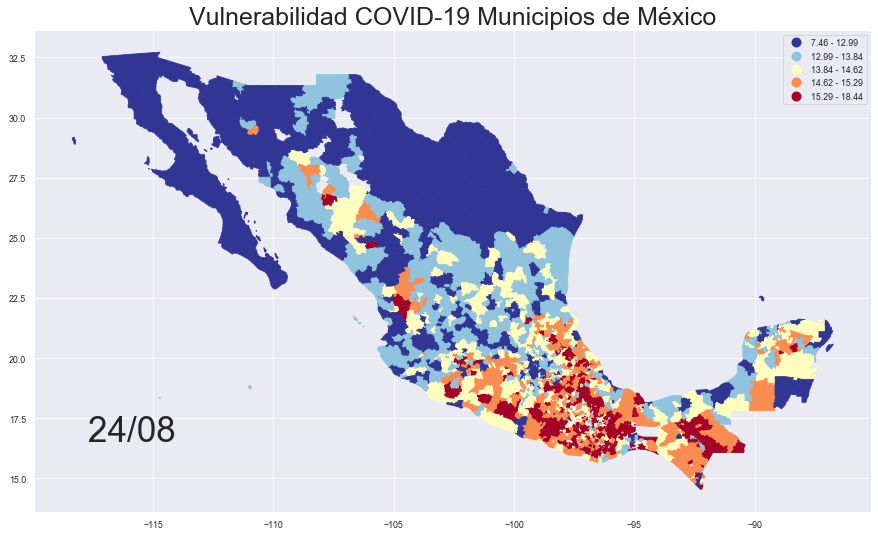

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
# cax = divider.append_axes("right", size="5%", pad=0.1)
fig = df[df.valor.notna()].plot(column='valor', 
                                cmap='RdYlBu_r',
                                scheme='Quantiles',
                                k=5,
                                ax=ax,
                                legend=True,
                                edgecolor='face')

# remove axis of chart
# fig.axis('off')
fig.set_title('Vulnerabilidad COVID-19 Municipios de México', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})
# position the annotation to the bottom left
fig.annotate(fecha_analisis.strftime("%d/%m"),
        xy=(0.1, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=35)


plt.show()

## Mapa de letalidad 1 de julio de 2020

La letalidad en esa fecha se distribuía de la siguiente manera.

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_analisis) &
                          (serie_vulnerabilidad.modelo == 'PLS')]

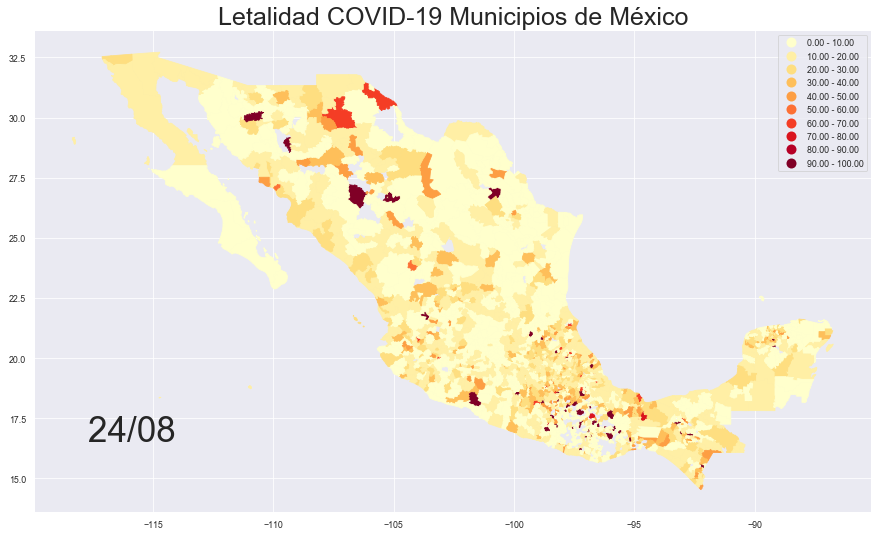

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
fig = df[df.tasa_covid_letal.notna()].plot(column='tasa_covid_letal', 
                                cmap='YlOrRd',
                                scheme='EqualInterval',
                                k=10,
                                ax=ax,
                                legend=True,
                                edgecolor='face')
# remove axis of chart
fig.set_title('Letalidad COVID-19 Municipios de México', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})
# position the annotation to the bottom left
fig.annotate(fecha_analisis.strftime("%d/%m"),
        xy=(0.1, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=35)


plt.show()

## Lista 10 municipios más vulnerables

De acuerdo con el índice, los diez municipios más vulnerables son los siguientes. Un dato notable es que de los diez municipios más vulnerables seis no tienen coasos reportados. En general los municipios más vulnerables son municipios con muy pocos casos, o sin casos.

In [ ]:
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.precision', 2)
campos_tablas = ['ENTIDAD_RES', 'MUNICIPIO_RES',
                  'valor',
                  'covid_confirmados_100k', 'tasa_covid_letal']
serie_vulnerabilidad.MUNICIPIO_RES = serie_vulnerabilidad.MUNICIPIO_RES.str.wrap(width=15)
serie_vulnerabilidad.ENTIDAD_RES = serie_vulnerabilidad.ENTIDAD_RES.str.wrap(width=15)

df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_analisis) &
                         (serie_vulnerabilidad.modelo == 'PLS')].copy()
display(Markdown(df.sort_values(by='valor', ascending=False).head(10)[campos_tablas].to_markdown(index=False)))

| ENTIDAD_RES   | MUNICIPIO_RES   |   valor |   covid_confirmados_100k |   tasa_covid_letal |
|:--------------|:----------------|--------:|-------------------------:|-------------------:|
| OAXACA        | SANTOS REYES    | 24.3968 |                  0       |                nan |
|               | YUCUNÁ          |         |                          |                    |
| GUERRERO      | COCHOAPA EL     | 23.6483 |                  5.17143 |                  0 |
|               | GRANDE          |         |                          |                    |
| OAXACA        | SAN JOSÉ        | 23.239  |                 26.3824  |                 20 |
|               | TENANGO         |         |                          |                    |
| VERACRUZ DE   | TEHUIPANGO      | 22.8224 |                  0       |                nan |
| IGNACIO DE LA |                 |         |                          |                    |
| LLAVE         |                 |         |                          |                    |
| OAXACA        | SANTIAGO NUYOÓ  | 22.6496 |                  0       |                nan |
| CHIAPAS       | CHALCHIHUITÁN   | 22.5789 |                  0       |                nan |
| OAXACA        | SAN MARTÍN      | 22.5725 |                  0       |                nan |
|               | PERAS           |         |                          |                    |
| OAXACA        | SAN SIMÓN       | 22.5486 |                  0       |                nan |
|               | ZAHUATLÁN       |         |                          |                    |
| VERACRUZ DE   | MIXTLA DE       | 22.4472 |                  0       |                nan |
| IGNACIO DE LA | ALTAMIRANO      |         |                          |                    |
| LLAVE         |                 |         |                          |                    |
| DURANGO       | MEZQUITAL       | 22.3785 |                 29.5617  |                  0 |

## Los 10 municipios menos vulnerables

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_analisis) &
                         ((serie_vulnerabilidad.modelo == 'PLS'))].copy()
display(Markdown(df.sort_values(by='valor').head(10)[campos_tablas].to_markdown(index=False)))

| ENTIDAD_RES   | MUNICIPIO_RES   |    valor |   covid_confirmados_100k |   tasa_covid_letal |
|:--------------|:----------------|---------:|-------------------------:|-------------------:|
| CIUDAD DE     | MIGUEL HIDALGO  |  9.01318 |                 580.838  |           10.0227  |
| MÉXICO        |                 |          |                          |                    |
| CIUDAD DE     | BENITO JUÁREZ   |  9.42706 |                 442.233  |           11.001   |
| MÉXICO        |                 |          |                          |                    |
| NUEVO LEÓN    | MONTERREY       |  9.57409 |                 226.967  |            7.16804 |
| CIUDAD DE     | CUAUHTÉMOC      |  9.84797 |                 576.37   |           14.7059  |
| MÉXICO        |                 |          |                          |                    |
| JALISCO       | GUADALAJARA     |  9.99799 |                 187.495  |           16.9564  |
| CHIHUAHUA     | CHIHUAHUA       | 10.0603  |                  84.7908 |           14.4099  |
| SONORA        | HERMOSILLO      | 10.7058  |                 511.81   |           10.1404  |
| NUEVO LEÓN    | SAN PEDRO GARZA | 10.7754  |                 119.174  |            6.70732 |
|               | GARCÍA          |          |                          |                    |
| NUEVO LEÓN    | SAN NICOLÁS DE  | 10.8423  |                 148.261  |           12.5178  |
|               | LOS GARZA       |          |                          |                    |
| CIUDAD DE     | GUSTAVO A.      | 10.8675  |                 584.383  |           17.3161  |
| MÉXICO        | MADERO          |          |                          |                    |

## Los 10 municipios con más de 500K habitantes más vulnerables

In [ ]:
pd.set_option('display.max_colwidth', 50)
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_analisis) &
                         ((serie_vulnerabilidad.modelo == 'PLS'))].copy()
datos_md = df[df.pob2020 > 500000].sort_values(by='valor',
                                         ascending=False).head(10)[campos_tablas].to_markdown(index=False)

display(Markdown(datos_md))

| ENTIDAD_RES   | MUNICIPIO_RES   |   valor |   covid_confirmados_100k |   tasa_covid_letal |
|:--------------|:----------------|--------:|-------------------------:|-------------------:|
| MÉXICO        | CHIMALHUACÁN    | 15.3797 |                 203.83   |           20.8447  |
| GUERRERO      | ACAPULCO DE     | 14.7936 |                 471.696  |           16.465   |
|               | JUÁREZ          |         |                          |                    |
| MÉXICO        | IXTAPALUCA      | 14.3567 |                 229.387  |           20.0949  |
| JALISCO       | TONALÁ          | 13.4767 |                  87.4205 |           13.0693  |
| MÉXICO        | NEZAHUALCÓYOTL  | 13.2867 |                 351.651  |           18.5779  |
| TAMAULIPAS    | MATAMOROS       | 13.2137 |                 302.867  |            8.34341 |
| CHIAPAS       | TUXTLA          | 13.1828 |                 312.108  |           13.588   |
|               | GUTIÉRREZ       |         |                          |                    |
| VERACRUZ DE   | XALAPA          | 13.1515 |                  99.5242 |           16.6341  |
| IGNACIO DE LA |                 |         |                          |                    |
| LLAVE         |                 |         |                          |                    |
| JALISCO       | SAN PEDRO       | 13.12   |                  96.5327 |           16.6667  |
|               | TLAQUEPAQUE     |         |                          |                    |
| MÉXICO        | ECATEPEC DE     | 13.1157 |                 290.381  |           19.2982  |
|               | MORELOS         |         |                          |                    |

## Los 10 municipios con más de 500K habitantes menos vulnerables

In [ ]:
datos_md = df[df.pob2020 > 500000].sort_values(by='valor').head(10)[campos_tablas].to_markdown(index=False)

In [ ]:
display(Markdown(datos_md))

| ENTIDAD_RES   | MUNICIPIO_RES   |    valor |   covid_confirmados_100k |   tasa_covid_letal |
|:--------------|:----------------|---------:|-------------------------:|-------------------:|
| NUEVO LEÓN    | MONTERREY       |  9.57409 |                 226.967  |            7.16804 |
| CIUDAD DE     | CUAUHTÉMOC      |  9.84797 |                 576.37   |           14.7059  |
| MÉXICO        |                 |          |                          |                    |
| JALISCO       | GUADALAJARA     |  9.99799 |                 187.495  |           16.9564  |
| CHIHUAHUA     | CHIHUAHUA       | 10.0603  |                  84.7908 |           14.4099  |
| SONORA        | HERMOSILLO      | 10.7058  |                 511.81   |           10.1404  |
| CIUDAD DE     | GUSTAVO A.      | 10.8675  |                 584.383  |           17.3161  |
| MÉXICO        | MADERO          |          |                          |                    |
| YUCATÁN       | MÉRIDA          | 10.9725  |                 295.686  |           10.3158  |
| NUEVO LEÓN    | APODACA         | 11.0193  |                 129.631  |            8.22711 |
| CIUDAD DE     | COYOACÁN        | 11.0195  |                 562.423  |           11.0349  |
| MÉXICO        |                 |          |                          |                    |
| COAHUILA DE   | SALTILLO        | 11.0324  |                  88.4738 |            5.46164 |
| ZARAGOZA      |                 |          |                          |                    |

# Datos

El índice de vulnerabilidad lo construimos relacionando indicadores de CONEVAL, INEGI y estadísticas CLUES, con la letalidad de COVID-19 observada en los municipios donde ya se han confirmado casos de infección de Sars-Cov-2.

Las fuentes de datos para el conjunto de indicadores pertenecen a cuatro categorías. La siguiente lista presenta la fuente y la categoría a la que pertence cada conjunto de indicadores:

1. Social:
    * Fuente: CONEVAL, rezago social, 2015
    * Producto: Índice de rezago social por municipio
    * URL: 
2. Economía:
    * Fuente: CONEVAL, pobreza, 2015
    * Producto: Indicadores de pobreza por municipio
    * URL: https://datos.gob.mx/busca/dataset/indicadores-de-pobreza-municipal-2010--2015
3. Salud:
    * Fuente: INEGI
    * Producto: estadísticas vitales, 2015
    * URL:
4. Infraestructura de salud:
    * Fuente: CLUES
    * Producto: 
    * URL:
    
    

# Método

Para construir el índice de vulnerabilidad integramos un conjunto de indicadores sociales, económicos y de salubridad y encontramos la combinación de estos que más se relaciona con el nivel de letalidad de COVID-19. Con esta combinación generamos el índice, el cuál nos indica el grado en que la población de un municipio es suceptible a tener complicaciones por COVID-19. 

En la práctica definimos vulnerabilidad como predispcición de una población a tener un índice de letalidad alta, por lo tanto buscamos la relación entre los indicadores y la letalidad observada de COVID-19 en municipios con presencia de la epidemia. Para buscar esta relación ajustamos una regresión considerando municipios con al menos diez casos confirmados. 

El método para construir este índice es regresión por mínimos cuadrados parciales. Este método busca la combinación de indicadores que explica más sobre la letalidad de COVID-19 en una población. Del ajuste obtenemos una función que calcula el índice de vulnerabilidad para cada municipio, y coeficientes para cada indicador, los cuáles nos indican la relevancia que cada uno tiene en el resultado del índice, dada por la magnitud del coeficiente, y según el signo también sabemos en que dirección se asocia el indicador con la letalidad, por ejemplo, como veremos más adelante, el indicador *npnv* (porcentaje de la población que no es pobre ni vulnerable de acuerdo con CONEVAL) es de los indicadores con mayor peso pero en sentido inverso.  

## Especificación modelo

* **Periódo de datos para el análisis**: 24 de abril al 1 de julio de 2020
* **URL**: [Datos abiertos de COVID-19](https://www.gob.mx/salud/documentos/datos-abiertos-bases-historicas-direccion-general-de-epidemiologia)
* **Implementación PLS**:  [Scikit Learn - PLSRegression](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression)

## Análisis por entidades

En esta sección presentamos como se distribuyen la letalidad y el índice de vulnerabilidad por entidad. El siguiente mapa muestra la vulnerabilidad promedio por entidad. 

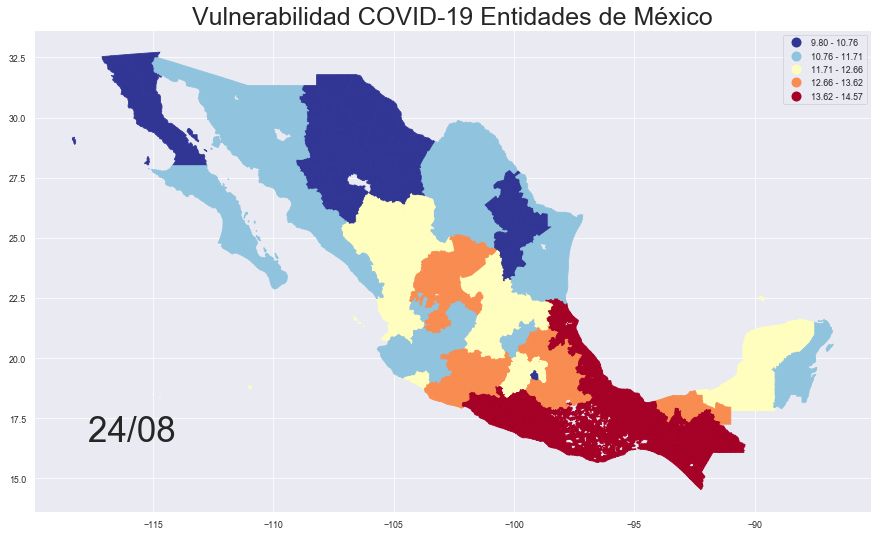

In [ ]:
ig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)

vulnerabilidad_entidad = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_analisis)  &
                                             (serie_vulnerabilidad.modelo == 'PLS')]
vulnerabilidad_entidad = vulnerabilidad_entidad[['ENTIDAD_RES','geometry', 'letalidad_entidad', 'valor_entidad']]
fig = vulnerabilidad_entidad.plot(ax=ax, column='valor_entidad', cmap='RdYlBu_r',
                                  scheme="EqualInterval", legend=True, k=5,
                                  edgecolor="face")

# remove axis of chart
fig.set_title('Vulnerabilidad COVID-19 Entidades de México', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})
# position the annotation to the bottom left
fig.annotate(fecha_analisis.strftime("%d/%m"),
        xy=(0.1, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=35)


plt.savefig(f'vulnerabilidad_entidades_{fecha_analisis.strftime("%y%m%d")}.png')

El siguiente muestra la letalidad promedio por entidad.

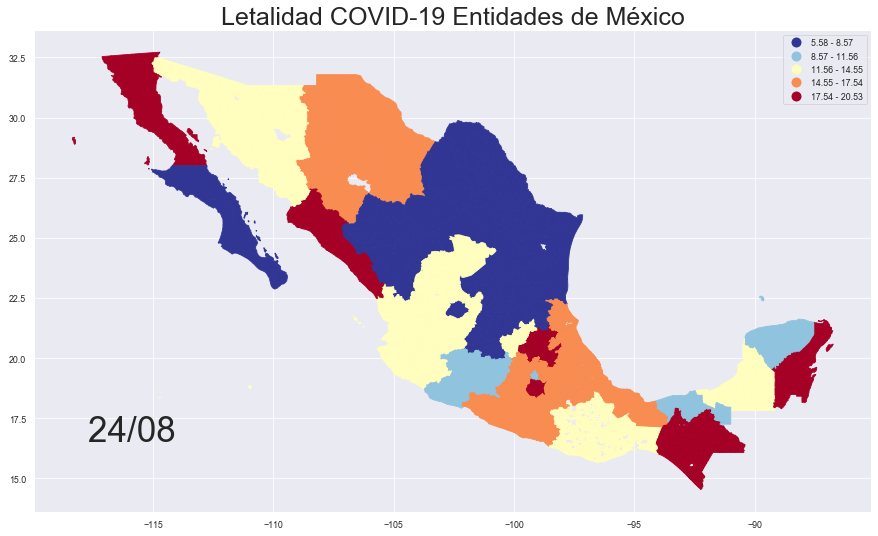

In [ ]:
ig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)

letalidad_entidad = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_analisis)  &
                                         (serie_vulnerabilidad.modelo == 'PLS')]
letalidad_entidad = letalidad_entidad[['ENTIDAD_RES', 'geometry', 'letalidad_entidad', 'valor_entidad']].drop_duplicates()
fig = letalidad_entidad.plot(ax=ax,
                             column='letalidad_entidad',
                             cmap='RdYlBu_r',
                             scheme="EqualInterval",
                            legend=True, k=5, edgecolor="face")

# remove axis of chart
fig.set_title('Letalidad COVID-19 Entidades de México', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})
# position the annotation to the bottom left
fig.annotate(fecha_analisis.strftime("%d/%m"),
        xy=(0.1, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=35)


plt.savefig(f'letalidad_entidades_{fecha_analisis.strftime("%y%m%d")}.png')

In [ ]:
datos = letalidad_entidad.sort_values(by='letalidad_entidad', ascending=False)
datos_md = datos.drop(columns='geometry').drop_duplicates().to_markdown(index=False)
display(Markdown(datos_md))

| ENTIDAD_RES                     |   letalidad_entidad |   valor_entidad |
|:--------------------------------|--------------------:|----------------:|
| QUINTANA ROO                    |            20.5273  |        11.6444  |
| BAJA CALIFORNIA                 |            20.5171  |        10.1785  |
| MORELOS                         |            20.1589  |        13.0109  |
| HIDALGO                         |            19.0068  |        13.4248  |
| CHIAPAS                         |            18.523   |        14.5737  |
| SINALOA                         |            18.5228  |        11.2372  |
| PUEBLA                          |            17.4492  |        13.1106  |
| TLAXCALA                        |            16.8594  |        13.5455  |
| VERACRUZ DE IGNACIO DE LA LLAVE |            16.2909  |        13.7763  |
| MÉXICO                          |            15.4337  |        12.6268  |
| CHIHUAHUA                       |            15.1654  |        10.132   |
| GUERRERO                        |            14.865   |        14.0785  |
| CAMPECHE                        |            14.2905  |        12.2615  |
| NAYARIT                         |            14.1132  |        12.1199  |
| SONORA                          |            13.9499  |        10.8394  |
| JALISCO                         |            13.4009  |        11.2667  |
| ZACATECAS                       |            13.287   |        12.7506  |
| QUERÉTARO                       |            13.1903  |        11.5839  |
| COLIMA                          |            12.2482  |        11.93    |
| OAXACA                          |            11.7526  |        14.1651  |
| YUCATÁN                         |            11.3482  |        11.7546  |
| TABASCO                         |            10.4951  |        12.9236  |
| MICHOACÁN DE OCAMPO             |            10.4847  |        13.5774  |
| CIUDAD DE MÉXICO                |             9.32059 |         9.80184 |
| NUEVO LEÓN                      |             8.54211 |        10.369   |
| SAN LUIS POTOSÍ                 |             8.50326 |        12.0471  |
| DURANGO                         |             8.32193 |        11.7525  |
| TAMAULIPAS                      |             8.05643 |        11.6719  |
| AGUASCALIENTES                  |             7.77989 |        10.9067  |
| COAHUILA DE ZARAGOZA            |             7.50349 |        10.7672  |
| GUANAJUATO                      |             7.08034 |        11.9829  |
| BAJA CALIFORNIA SUR             |             5.58436 |        11.0446  |

### Letalidad por entidad

El siguiente diagrama de cajas muestra cómo se distribuye la letalidad para cada entidad, considerando municipios con más de **3** defunciones por COVID-19 reportadas. Cada punto es un municipio donde la altura representa la letalidad de COVID-19 observada en ese muncipio. 

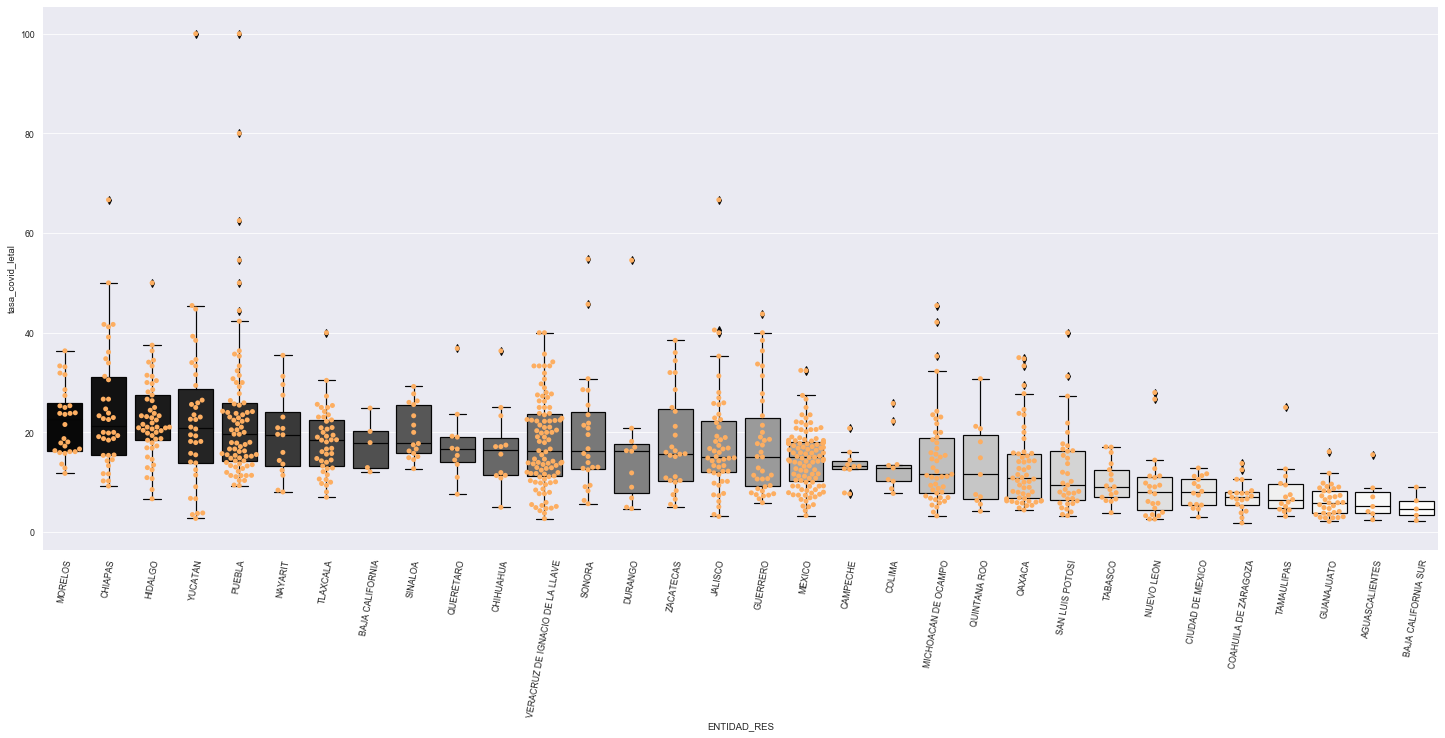

In [ ]:
f, ax = plt.subplots(figsize=(25, 10))
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_analisis) &
                          (serie_vulnerabilidad.defunciones > 3)  &
                          (serie_vulnerabilidad.modelo == 'PLS')].copy()
df['mean_val'] = df.groupby('ENTIDAD_RES')['tasa_covid_letal'].transform('median')
df.sort_values(by='mean_val', ascending=False, inplace=True)

sns.boxplot(data=df, y='tasa_covid_letal', x='ENTIDAD_RES', saturation=0.3, palette='Greys_r')
sns.swarmplot(data=df, y='tasa_covid_letal', x='ENTIDAD_RES', color='#fdae61')
plt.xticks(rotation=80)
sns.despine(trim=True, left=True)

De los municpios desplegados arriba los municipios con mayor letalidad son:

In [ ]:
datos_md = df.sort_values(by='tasa_covid_letal', ascending=False)[campos_tablas].head(10).to_markdown(index=False)
display(Markdown(datos_md))

| ENTIDAD_RES   | MUNICIPIO_RES           |   valor |   covid_confirmados_100k |   tasa_covid_letal |
|:--------------|:------------------------|--------:|-------------------------:|-------------------:|
| PUEBLA        | COHETZALA               | 15.1411 |                 353.357  |           100      |
| YUCATÁN       | SANAHCAT                | 13.3144 |                 218.699  |           100      |
| PUEBLA        | ACTEOPAN                | 15.8619 |                 159.642  |            80      |
| JALISCO       | SAN JUANITO DE ESCOBEDO | 12.8371 |                  60.2349 |            66.6667 |
| CHIAPAS       | IXTAPANGAJOYA           | 15.2375 |                 100.2    |            66.6667 |
| PUEBLA        | CHILCHOTLA              | 16.0817 |                  38.1243 |            62.5    |
| SONORA        | BENITO JUÁREZ           | 13.0394 |                 176.152  |            54.7619 |
| PUEBLA        | NEALTICAN               | 15.7817 |                  83.3965 |            54.5455 |
| DURANGO       | NOMBRE DE DIOS          | 13.2633 |                  52.6795 |            54.5455 |
| PUEBLA        | SANTA ISABEL CHOLULA    | 15.4909 |                 127.321  |            50      |

El criterio de desplegar municipios con más de 3 defunciones se aplicó para limpiar los datos. A continuación se presenta el mismo diagrama pero considerando todos los municipios con casos de Sars-CoV-2, se observa que hay varios municipios con cero defunciones y otros con letalidad de 100%, estos dos casos extremos se presentan con mayor frecuencia y se salen de la distribución de valores de letalidad, esto sucede en general con municpios que han reportado pocos casos. 

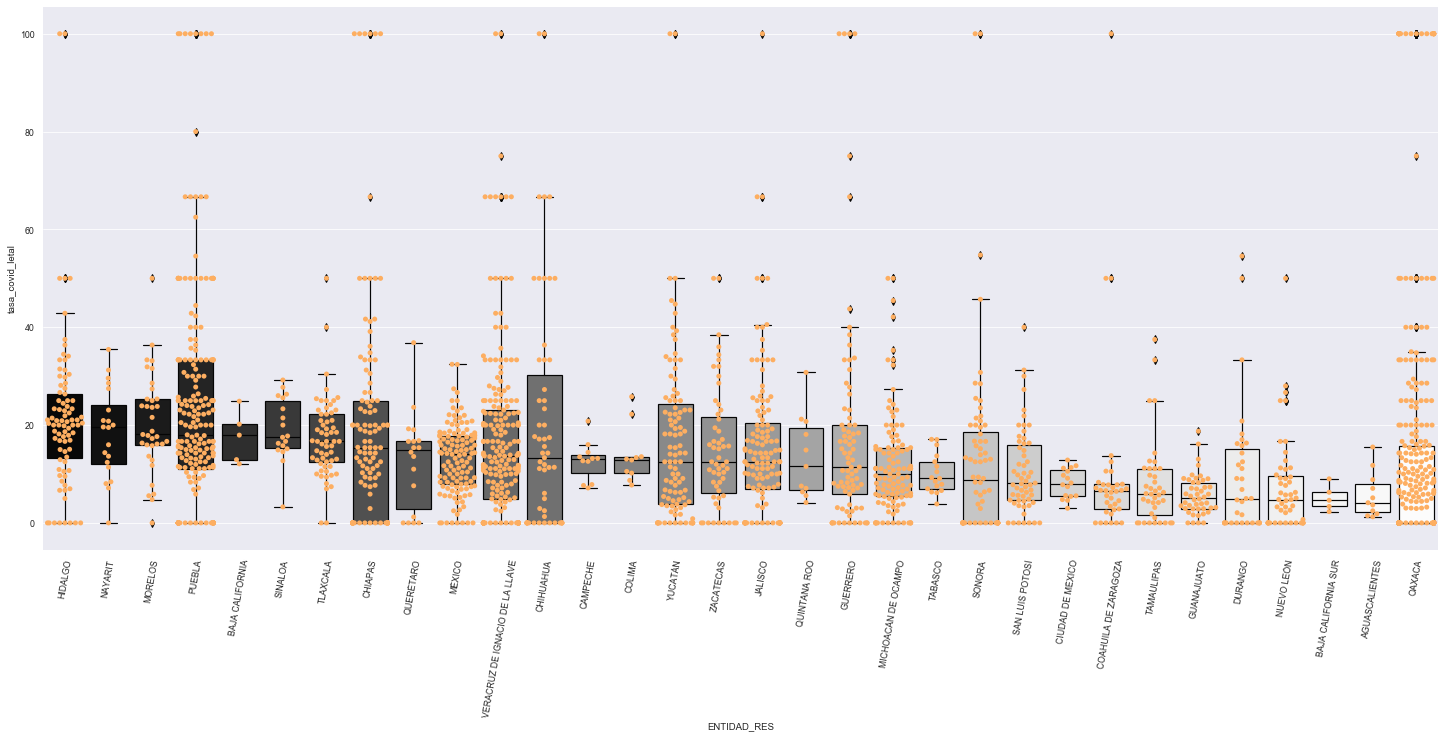

In [ ]:
f, ax = plt.subplots(figsize=(25, 10))
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_analisis) &
                          (serie_vulnerabilidad.modelo == 'PLS')].copy()
df['mean_val'] = df.groupby('ENTIDAD_RES')['tasa_covid_letal'].transform('median')
df.sort_values(by='mean_val', ascending=False, inplace=True)

sns.boxplot(data=df[df.conteo > 0], y='tasa_covid_letal', x='ENTIDAD_RES', saturation=0.3, palette='Greys_r')
sns.swarmplot(data=df[df.conteo > 0], y='tasa_covid_letal', x='ENTIDAD_RES', color='#fdae61')
plt.xticks(rotation=80)
sns.despine(trim=True, left=True)

### Vulnerabilidad por entidad

La siguiente gráfica muestra la distribución de vulnerabilidad de los municipios por entidad. Al igual que en la anterior, cada punto representa un municipio y la posición en el eje *y* está dada por el valor del índice de vulnerabilidad. El orden en el que se despliegan las entidades está dado por la mediana de vulnerabilidad.

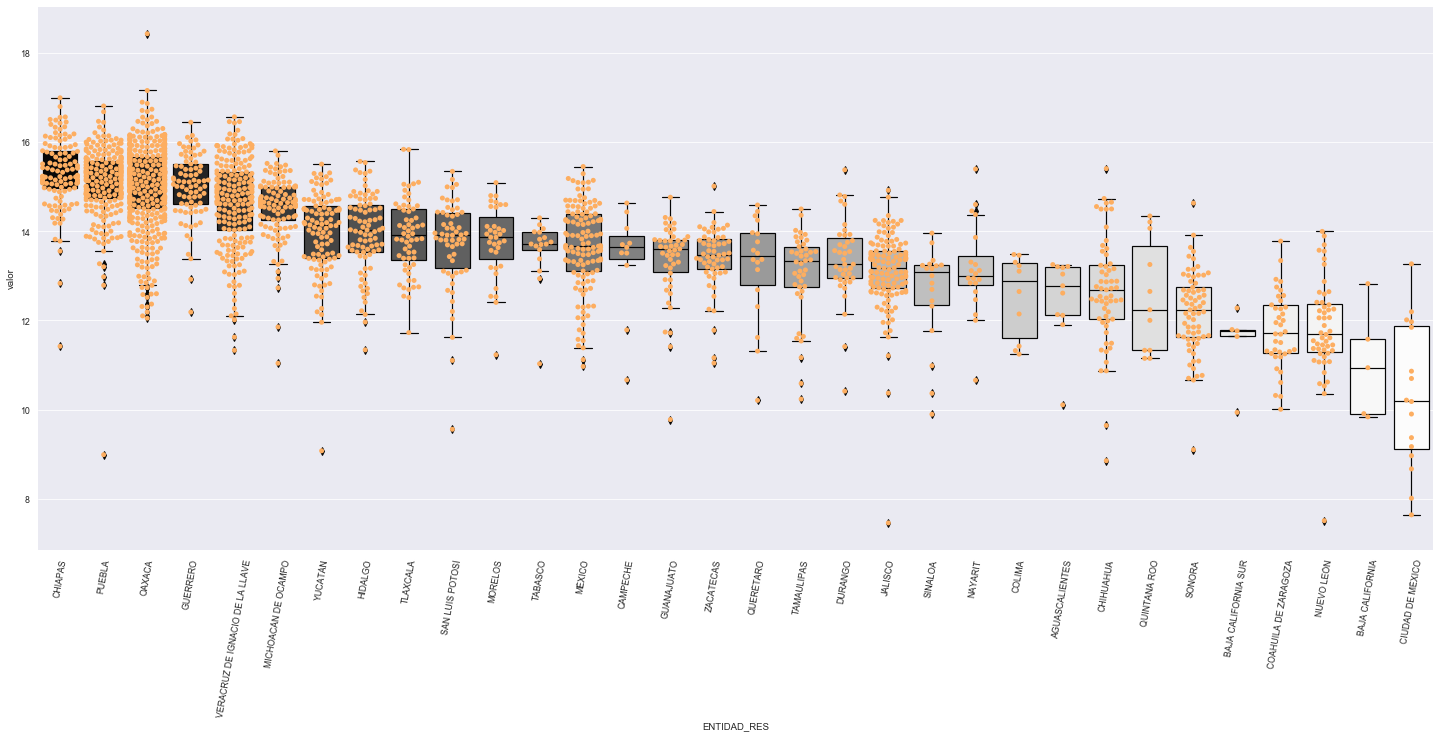

In [ ]:
f, ax = plt.subplots(figsize=(25, 10))
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_analisis)
                           &
                          (serie_vulnerabilidad.modelo == 'PLS')].copy()
df['mean_val'] = df.groupby('ENTIDAD_RES')['valor'].transform('median')
sns.boxplot(data=df.sort_values(by='mean_val', ascending=False), y='valor', x='ENTIDAD_RES', palette='Greys_r')
sns.swarmplot(data=df.sort_values(by='mean_val', ascending=False), y='valor', x='ENTIDAD_RES', color='#fdae61')
plt.xticks(rotation=80)
sns.despine(trim=True, left=True)

### Relación entre el índice de vulnerabilidad y la letalidad

In [ ]:
reg_df = df[(df.defunciones > 0) & df.valor.notna()]
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)

Los resultados muestran que para municipios donde existen defunciones reportadas, la correlación entre el índice de vulnerabilidad y la letalidad es positiva. Si calculamos la correlación de Spearman entre letalidad y vulnerabilidad para los municipios con al menos una defunción obtenemos:

In [ ]:
print('Correlación de Spearman: %.3f' % corr)

Correlación de Spearman: 0.323


In [ ]:
reg_df = df[(df.defunciones > 5) & df.valor.notna()]
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)

##### Si cambiamos a municipios con al menos 5 defunciones reportadas, la correlación aumenta aproximadamente 15% a:

In [ ]:
print('Correlación de Spearman: %.3f' % corr)

Correlación de Spearman: 0.363


En los siguientes diagramas de dispersión mostramos esta relación. En el primer diagrama desplegamos todos los municipios con al menos una defunción reportada. Ahí podemos ver las líneas verticales de puntos generadas por municipios con pocas defunciones reportadas (entre una y tres defunciones).

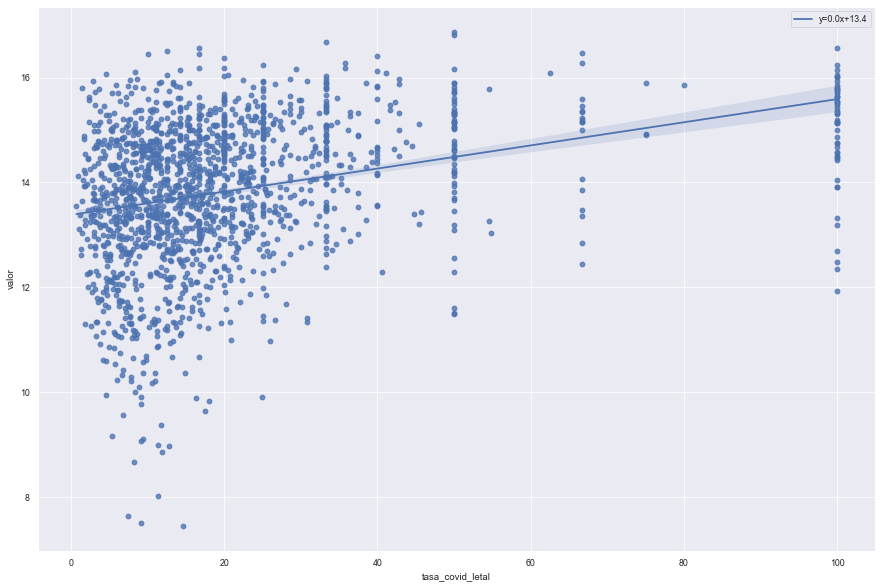

In [ ]:
reg_df = df[(df.defunciones > 0) & df.valor.notna()]
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
            line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

Si eliminamos esos municipios y desplegamos unicamente los que tienen al menos 5 defunciones reportadas se eliminan por completo esas líneas y mejora la relación entre las variables.

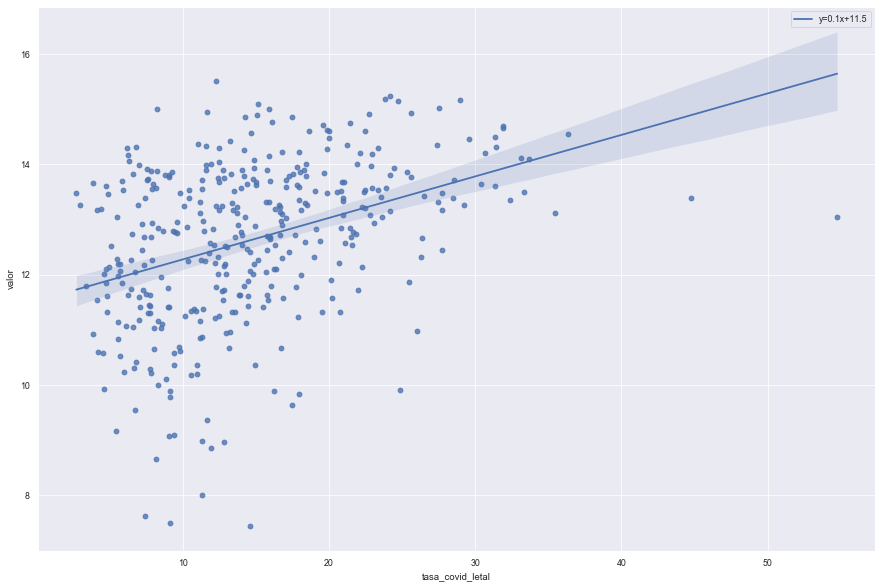

In [ ]:
reg_df = df[(df.defunciones > 20)]
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

## Serie de modelos PLS (24/04/2020 - 01/07/2020)

El ajuste de la regresión por PLS asigna coeficientes a cada uno de los indicadores que estamos considerando, donde la magnitud del coeficiente nos indica el tamaño de la relación que se encontró entre el indicador y la letalidad, y el signo nos indica si la relación es proporcional, es decir, si valores grandes del indicador se relacionan con alta vulnerabilidad, o es inversamente proporcional, si conforme crece el valor del indicador decrece el de vulnerabilidad.

El siguiente es un análisis de los modelos resultantes de ajustar una regresión por cada conjunto de datos publicado en el periódo que va del 24/04/2020 al 01/07/2020, es decir para cada día se calculó un modelo de vulnerabilidad. A continuación mostramos las descripciones de los indicadores y cómo se mueven sus coeficientes conforme cambian los datos.

### Descripción de los indicadores

In [ ]:
modelos_periodo = modelos[(modelos.dia_ajuste < fecha_analisis) & (modelos.modelo == 'PLS')].copy()
modelos_periodo['mediana'] = modelos_periodo.groupby('caracteristica')['coef'].transform('median')

In [ ]:
# from ipypublish import nb_setup
# pd = nb_setup.setup_pandas(escape_latex=False)

lista_cars = list(modelos_periodo.sort_values(by='mediana', ascending=False)["caracteristica"].drop_duplicates())
pd.set_option('display.max_colwidth', 0)

diccionario_indicadores = diccionario_indicadores.set_index('campo').loc[lista_cars].reset_index()
diccionario_indicadores

diccionario_indicadores.campo = diccionario_indicadores.campo.str.strip()
diccionario_indicadores.descriptor = diccionario_indicadores.descriptor.str.wrap(width=60)
diccionario_indicadores.descriptor = diccionario_indicadores.descriptor.str.strip()
dicc_md = diccionario_indicadores.to_markdown(index=False)
display(Markdown(dicc_md))

| campo                     | descriptor                                                                              |
|:--------------------------|:----------------------------------------------------------------------------------------|
| vnl_2015                  | Viviendas que no disponen de lavadora,2015                   |
| vnr_2015                  | Viviendas que no disponen de refrigerador,2015               |
| pobreza                   | % Población en situación de pobreza                          |
| plb                       | %Población con igreso inferior a la línea de bienestar       |
| pobreza_m                 | %Población en situación de pobreza moderada                  |
| carencias                 | %Población con al menos una carencia social                  |
| tasa_diabetes             | Diabetes mellitus.                                           |
| ic_segsoc                 | %Carencia por acceso a la seguridad social                   |
| plbm                      | %Población con ingreso inferior a la línea de bienestar      |
|                           | mínimo                                                       |
| ic_ali                    | %Carencia por acceso a la alimentación                       |
| irs_2015                  | Índice de rezago social,2015                                 |
| pobreza_e                 | %Población en situación de pobreza extrema                   |
| ic_asalud                 | %Carencia por acceso a los servicios de salud                |
| carencias3                | %Población con al menos tres carencias sociales              |
| ic_cv                     | %Carencia por calidad y espacios en la vivienda              |
| sins_15                   | Porcentaje de Población  sin derechohabiencia a salud,2015   |
| an_2015                   | 15 años y más analfabetas,2015                               |
| vna_2015                  | Viviendas sin Agua,2015                                      |
| ic_sbv                    | %Carencia por acceso a los servicios básicos en la vivienda  |
| bi_2015                   | 15 años y más con educación básica incompleta,2015           |
| ic_rezedu                 | %Indicadores de carencia social  Rezago educativo            |
| vpt_2015                  | Viviendas piso  de tierra,2015                               |
| vns_2015                  | Viviendas sin sanitario,2015                                 |
| hospitales_pemex          | Unidades econmicas dedicadas principalmente a proporcionar                                                              |
|                           | servicios médicos, que cuentan con las instalaciones para                                                               |
|                           | la hospitalizaci³n de los pacientes.                                                                                    |
| vnd_2015                  | Viviendas que no disponen de drenaje,2015                    |
| ne614_015                 | 6 a 14 años que no asisten a la escuela,2015                 |
| vne_2015                  | Viviendas que no disponen de energía eléctrica,2015          |
| hospitales_privados       | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| hospitales_sme            | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| farmacias                 | Unidades económicas dedicadas principalmente al comercio al  |
|                           | por menor de medicamentos, productos naturistas y            |
|                           | complementos alimenticios para consumo humano.               |
| tasa_pulmonares           | Enfermedades del sistema respiratorio, Influenza (gripe),    |
|                           | Neumoní­a, Otras infecciones agudas de las ví­as             |
|                           | respiratorias inferiores y Enfermedades crónicas de las      |
|                           | ví­as respiratorias inferiores.                              |
| consulto_1                | Unidades económicas de dicadas principalmente a proporcionar |
|                           | servicios de consulta médica externa general o especializada |
|                           | (como servicios médicos especializados en cardiología,       |
|                           | gastroenterología, otorrinolaringología, ginecología,        |
|                           | homeopatí­a, nutrición, psiquiatrí­a, oftalmología)          |
|                           | prestados por profesionistas con estudios mí­nimos de        |
|                           | licenciatura en medicina.                                    |
| porc_carencia_salud       | Se considera que una persona se encuentra en situación de    |
|                           | carencia por acceso a los servicios de salud cuando:  No     |
|                           | cuenta con adscripción o derecho a recibir servicios médicos |
|                           | de alguna institución que los presta, incluyendo el Seguro   |
|                           | Popular, las instituciones públicas de seguridad social      |
|                           | (IMSS, ISSSTE federal o estatal, Pemex, Ejí©rcito o Marina)  |
|                           | o los servicios médicos privados.                            |
| hospitales_semar          | Unidades econmicas dedicadas principalmente a proporcionar                             |
|                           | servicios mdicos, que cuentan con las instalaciones para la                            |
|                           | hospitalización de los pacientes.                                                       |
| hospitales_imss           | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| vul_car                   | %Población vulnerable por carencias sociales                 |
| total_de_camas_privados   | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| consultori                | Unidades económicas de dicadas principalmente a proporcionar |
|                           | servicios de consulta médica externa general o especializada |
|                           | (como servicios médicos especializados encardiología,        |
|                           | gastroenterología, otorrinolaringología, ginecología,        |
|                           | homeopatí­a, nutrición, psiquiatrí­a, oftalmología)          |
|                           | prestados por profesionistas con estudios mí­nimos de        |
|                           | licenciatura en medicina.                                    |
| total_camas               | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| tasa_cancer               | Tumores (neoplasias), Tumores malignos del labio, de la      |
|                           | cavidad bucal y de la faringe, Tumor maligno del esófago,    |
|                           | Tumor maligno del estómago, Tumor maligno del colon, del     |
|                           | recto y del ano, Tumor maligno del hí­gado y de las ví­as    |
|                           | biliares intrahepáticas, Tumor maligno del páncreas, Tumor   |
|                           | maligno de la laringe, Tumor maligno de la tráquea, de los   |
|                           | bronquios y del pulmón, Melanoma maligno de la piel, Tumor   |
|                           | maligno de la mama, Tumor maligno del cuello del útero,      |
|                           | Tumor maligno de otras partes y de las no especificadas del  |
|                           | útero, Tumor maligno del ovario, Tumor maligno de la         |
|                           | próstata, Tumor maligno de la vejiga urinaria, Tumor maligno |
|                           | de las meninges, del encí©falo y de otras partes del sistema |
|                           | nervioso central, Linfoma no Hodgkin, Mieloma múltiple y     |
|                           | tumores malignos de cí©lulas plasmáticas y Leucemia.         |
| total_camas_publicos      | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| hospitales_sedena         | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| tasa_cardiacas            | Enfermedades del sistema circulatorio, Fiebre reumática      |
|                           | aguda y enfermedades cardí­acas reumáticas crónicas,         |
|                           | Enfermedades hipertensivas, Enfermedades isquí©micas del     |
|                           | corazón, Otras enfermedades del corazón, Enfermedades        |
|                           | cerebrovasculares y Aterosclerosis.                          |
| vul_ing                   | %Población vulnerable por ingresos                           |
| total_hospitales_publicos | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| hospitales_ssa            | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| hospitales_issste         | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| lmex_2015                 | Lugar que ocupa en el contexto nacional,2015                 |
| npnv                      | %Población no pobre y no vulnerable                          |

### Distribución de valores de coeficientes por indicador

Este diagrama de cajas muestra los indicadores ordenados con respecto a la mediana de sus coeficientes, en él podemos ver el rango en el que se movieron los coeficientes a lo largo del periodo. Es importante notar que aunque los coeficientes de algunos indicadores se mueven en rangos relativamente amplios, en su mayoría se mantienen o en valores positivos o en negativos. 

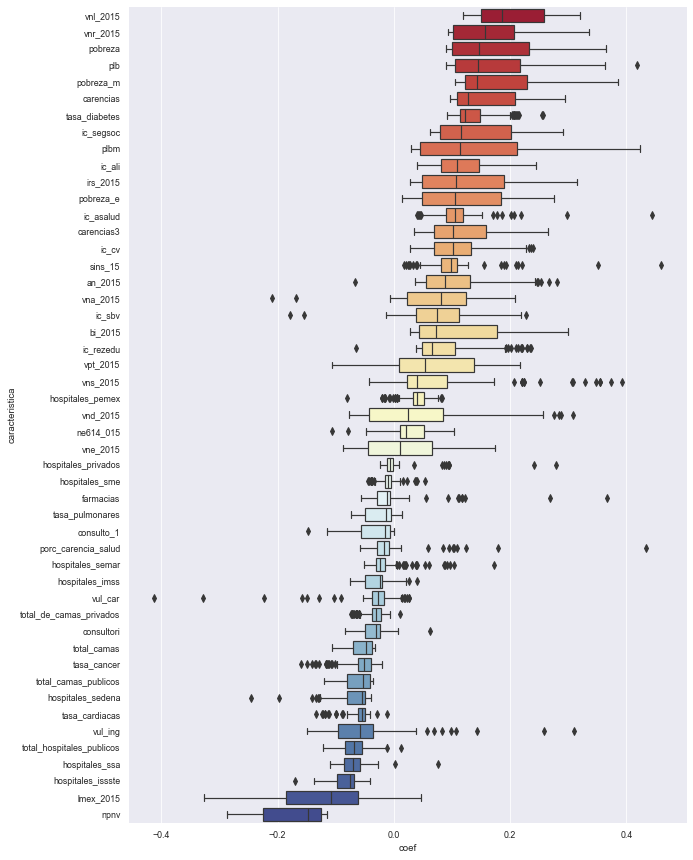

In [ ]:
# pd.set_option('display.max_colwidth', 50)
# Plot the orbital period with horizontal boxes
f, ax = plt.subplots(figsize=(10, 15))
sns.boxplot(y="caracteristica", x="coef", data=modelos_periodo.sort_values(by='mediana', ascending=False), palette='RdYlBu')
sns.despine(trim=True, left=True)

### Series de tiempo de coeficientes por indicador

Las siguientes gráficas muestran cómo cambian los coeficientes de los indicadores conforme avanzamos en el día de publicación del conjunto de datos. En general se puede ver que los coeficientes se estabilizan a medida que avanza el tiempo. Además de entender cómo cambia el resultado del ajuste conforme se actualizan los datos, este análisis es una herramienta que podría ayudarnos a detectar cambios en el patrón de letalidad de la epidemia.  

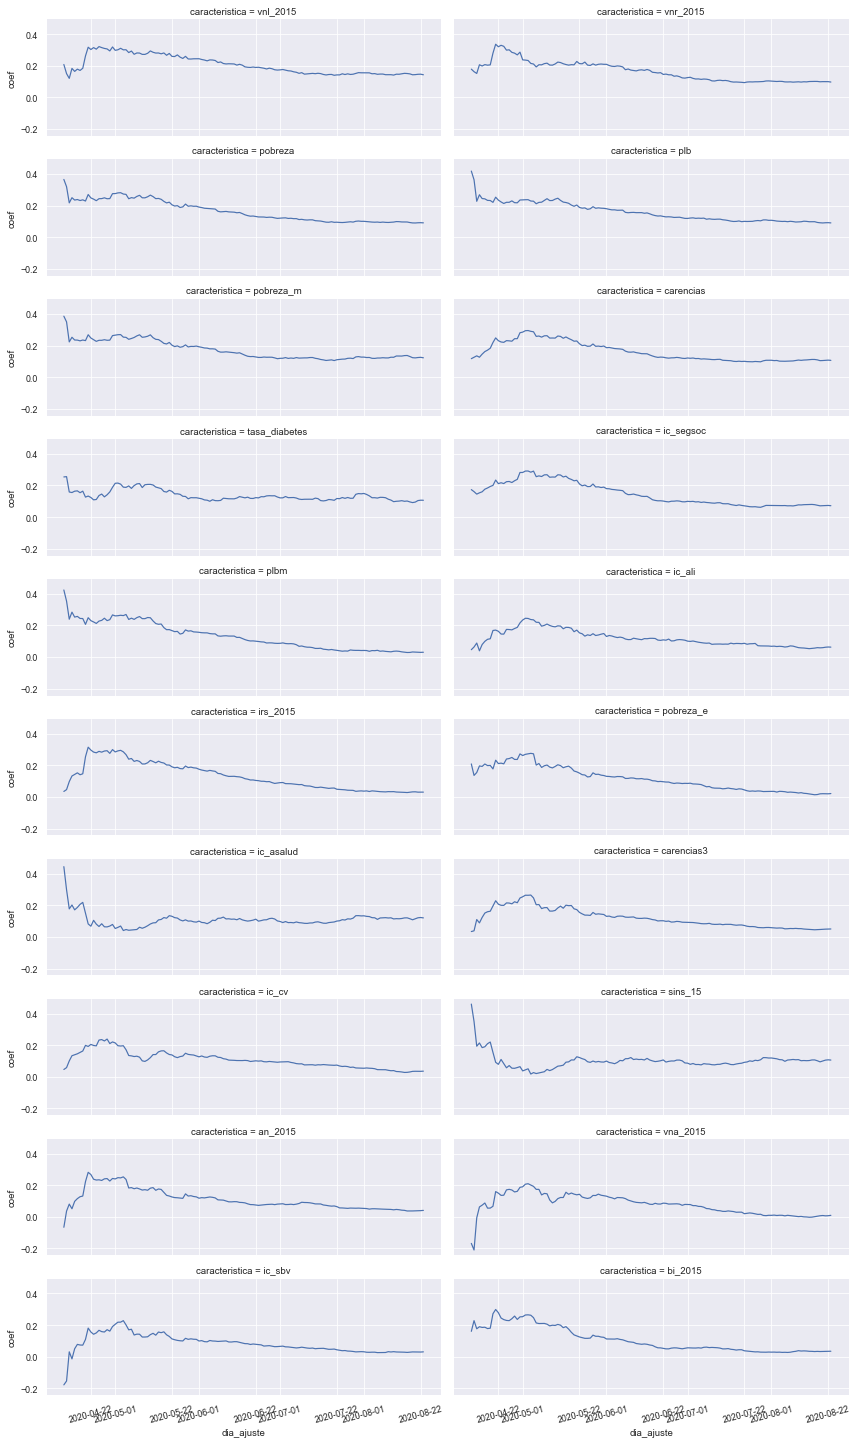

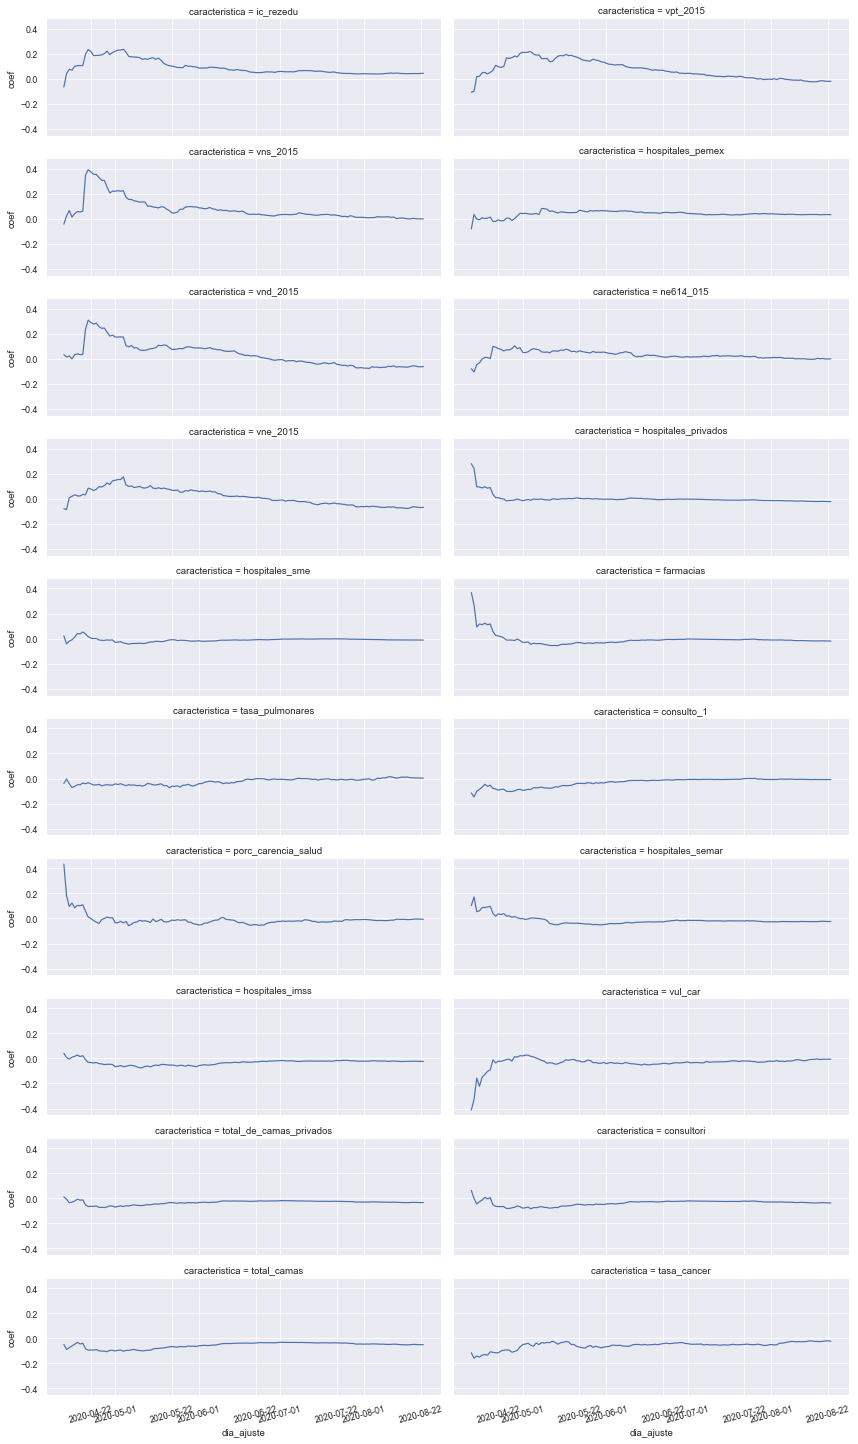

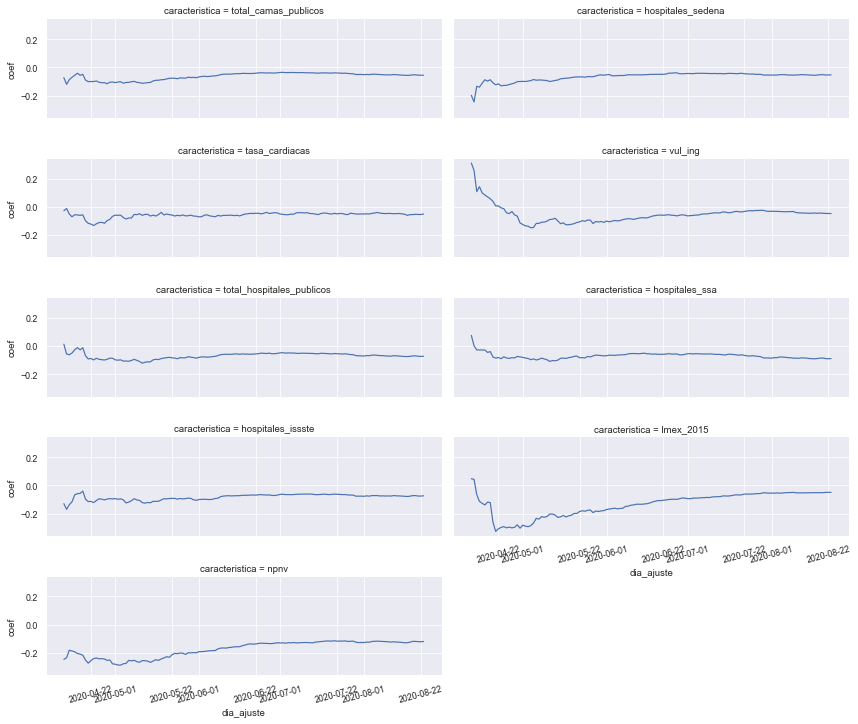

In [ ]:
orden_plots = modelos_periodo.sort_values(by='mediana', ascending=False)['caracteristica'].drop_duplicates()

g = sns.FacetGrid(modelos_periodo, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[:20])
g.map(sns.lineplot, 'dia_ajuste', "coef")
g.set_xticklabels(rotation=15)
plt.show()


g = sns.FacetGrid(modelos_periodo, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[20:40])
g.map(sns.lineplot, 'dia_ajuste', "coef")
g.set_xticklabels(rotation=15)
plt.show()

g = sns.FacetGrid(modelos_periodo, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[40:])
g.map(sns.lineplot, 'dia_ajuste', "coef")
g.set_xticklabels(rotation=15)
plt.show()

# sns.pointplot(data=plss[plss.caracteristica == 'ic_rezedu'], x='dia_ajuste', y='coef')

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_analisis)].copy()
df.drop(columns='geometry', inplace=True)
df.to_csv('vulnerabilidad_200601.csv')

### Comparación municipios urbanos y no urbanos

In [ ]:
modelos_urbanos, serie_urbanos = calcular_vulnerabilidad_urbana('200424', '200701', min_casos=20)

IntProgress(value=0, max=68)

In [ ]:
serie_urbanos.drop(columns='geometry').head()

CLAVE_MUNICIPIO_RES CLAVE_ENTIDAD_RES              MUNICIPIO_RES  \
0  01001               01                AGUASCALIENTES              
1  01005               01                JESÚS MARÍA                 
2  01011               01                SAN FRANCISCO DE LOS ROMO   
3  02002               02                MEXICALI                    
4  02003               02                TECATE                      

             RESULTADO      ENTIDAD_RES  conteo  defunciones  pt_2015  \
0  Positivo SARS-CoV-2  AGUASCALIENTES   126.0   2.0          877190    
1  Positivo SARS-CoV-2  AGUASCALIENTES   7.0     0.0          120405    
2  Positivo SARS-CoV-2  AGUASCALIENTES   2.0     0.0          46454     
3  Positivo SARS-CoV-2  BAJA CALIFORNIA  399.0   31.0         988417    
4  Positivo SARS-CoV-2  BAJA CALIFORNIA  35.0    3.0          102406    

   an_2015  ne614_015  ...  total_de_camas_privados  total_camas  pob2020  \
0  2.06     3.48       ...  43                       1271         961977    
1  3.24     4.13       ...  0                        297          130184    
2  2.93     3.87       ...  0                        0            51568     
3  1.54     3.05       ...  249                      1176         1087478   
4  2.31     2.14       ...  3                        122          113857    

   CVE_MUN  covid_confirmados_100k  covid_defun_100k  tasa_covid_letal  \
0  001      13.10                   0.21              1.59               
1  005      5.38                    0.00              0.00               
2  011      3.88                    0.00              0.00               
3  002      36.69                   2.85              7.77               
4  003      30.74                   2.63              8.57               

       modelo  dia_ajuste  valor  
0  PLS_URBANO 2020-04-24   7.60   
1  PLS_URBANO 2020-04-24   7.81   
2  PLS_URBANO 2020-04-24   7.60   
3  PLS_URBANO 2020-04-24   7.75   
4  PLS_URBANO 2020-04-24   8.29   

[5 rows x 92 columns]

In [ ]:
df = serie_urbanos[((serie_urbanos.modelo == 'PLS_URBANO') | (serie_urbanos.modelo == 'PLS_NO_URBANO')) &
                   (serie_urbanos.dia_ajuste == datetime.datetime(2020, 7, 1))]

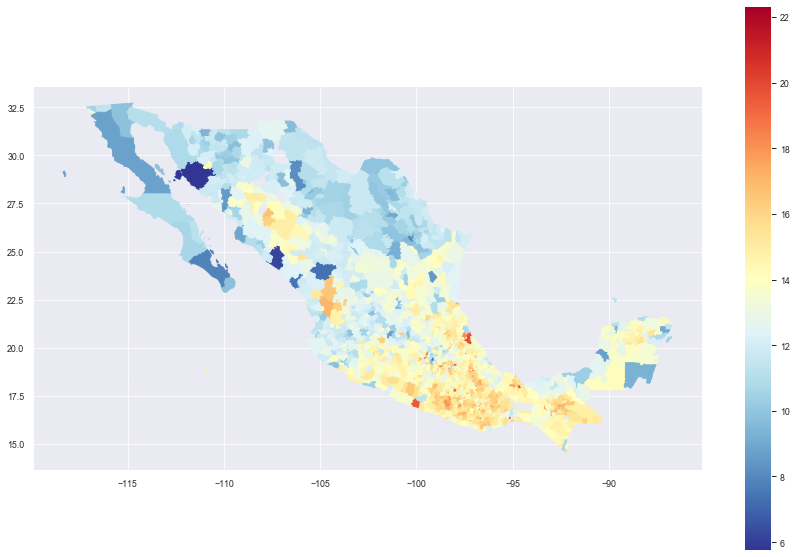

In [ ]:
df[df.valor.notna()].plot(column='valor', figsize=(15, 10), edgecolor='face', cmap='RdYlBu_r', legend=True)
plt.show()

In [ ]:
df = serie_urbanos[((serie_urbanos.modelo == 'PLS_URBANO')) &
                   (serie_urbanos.dia_ajuste == datetime.datetime(2020, 7, 1))]

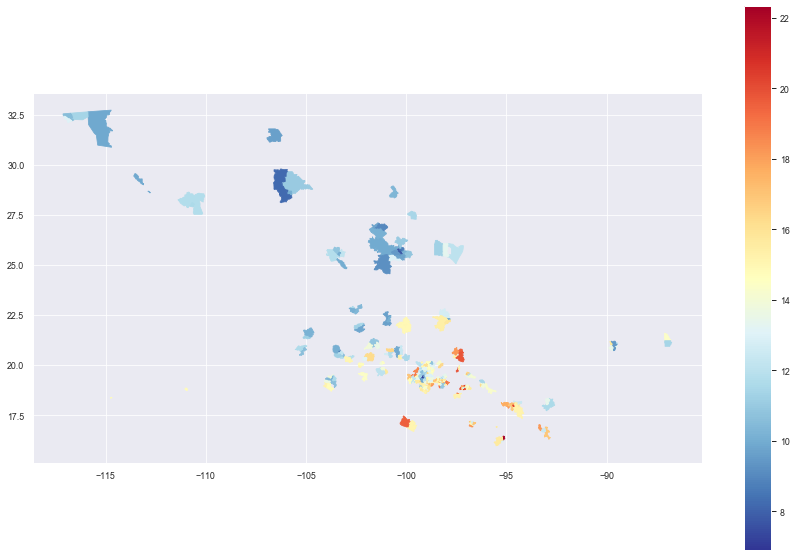

In [ ]:
df[df.valor.notna()].plot(column='valor', figsize=(15, 10), edgecolor='face', cmap='RdYlBu_r', legend=True)
plt.show()

In [ ]:
df = serie_urbanos[((serie_urbanos.modelo == 'PLS_NO_URBANO')) &
                   (serie_urbanos.dia_ajuste == datetime.datetime(2020, 7, 1))]

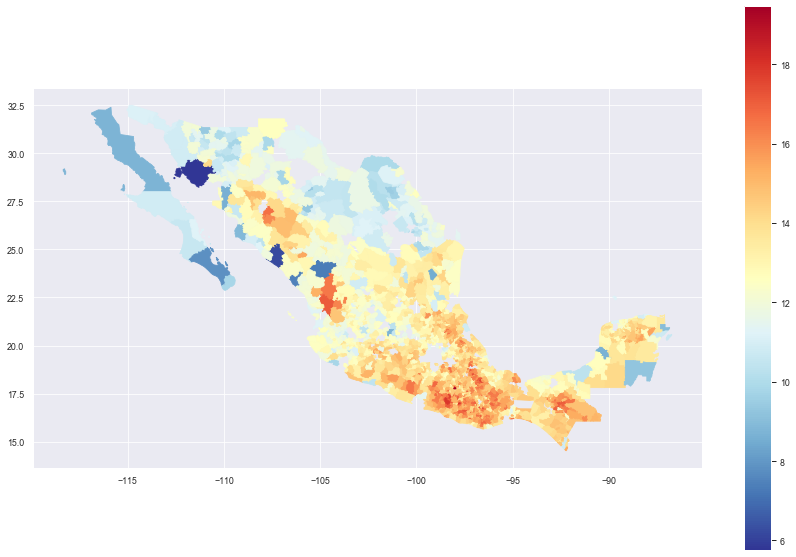

In [ ]:
df[df.valor.notna()].plot(column='valor', figsize=(15, 10), edgecolor='face', cmap='RdYlBu_r', legend=True)
plt.show()

In [ ]:
modelos_urbanos['mediana'] = modelos_urbanos.groupby(['caracteristica', 'modelo'])['coef'].transform('median')


In [ ]:
modelos_urbanos.head()

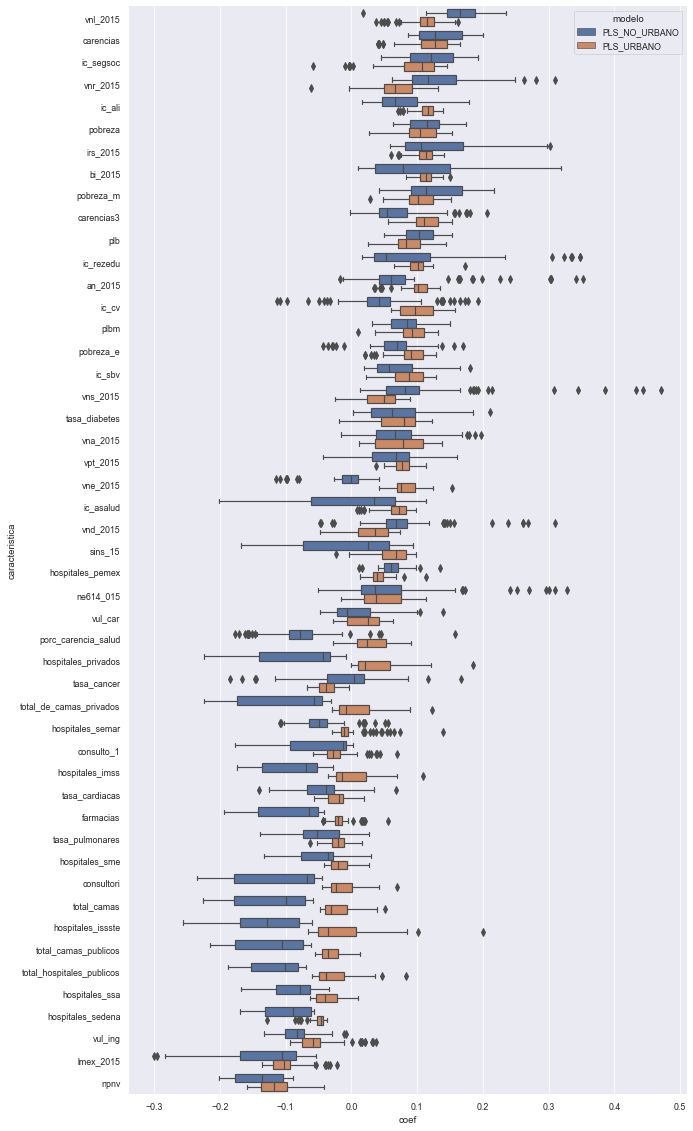

In [ ]:
# Plot the orbital period with horizontal boxes
f, ax = plt.subplots(figsize=(10, 20))
sns.boxplot(y="caracteristica",
            x="coef",
            data=modelos_urbanos.sort_values(by='mediana', ascending=False),
            hue='modelo')
sns.despine(trim=True, left=True)

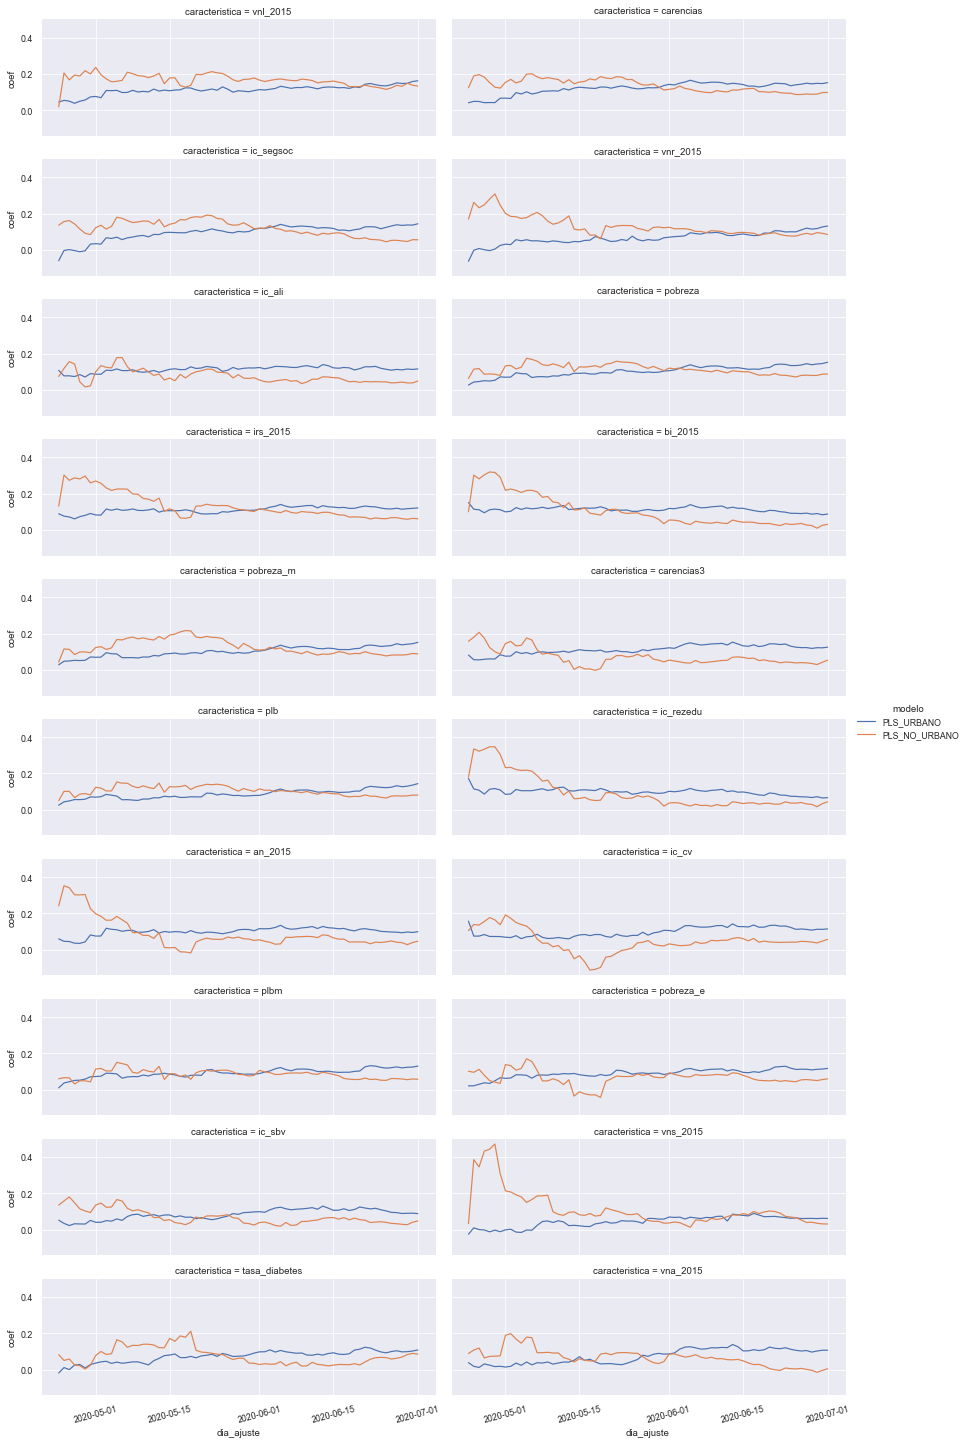

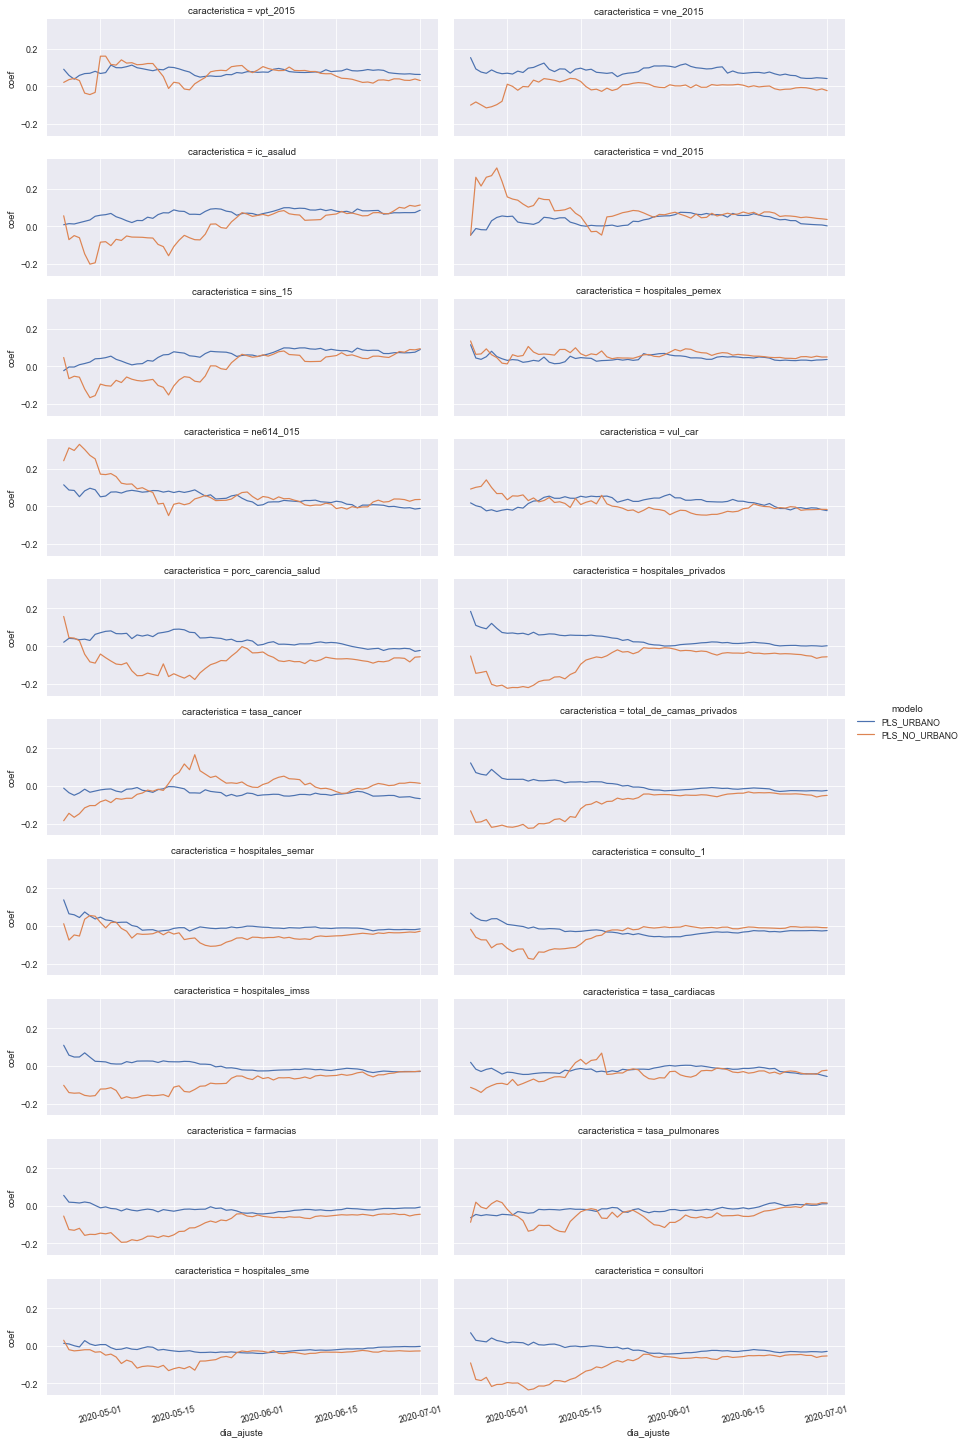

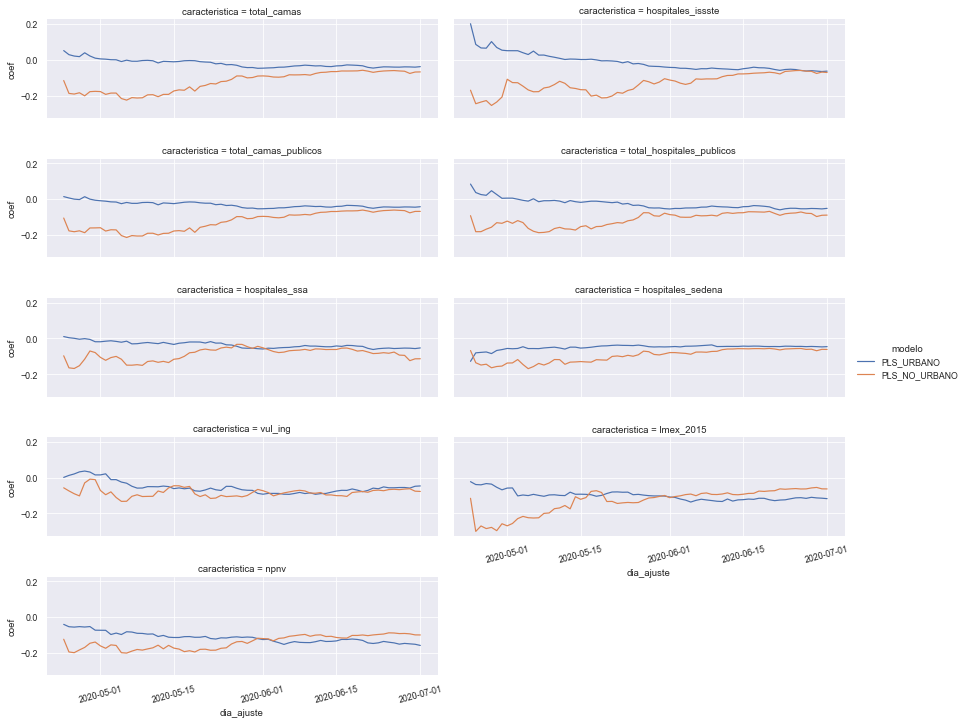

In [ ]:
# ordered_days = tips.day.value_counts().index
orden_plots = modelos_urbanos.sort_values(by='mediana', ascending=False)['caracteristica'].drop_duplicates()

g = sns.FacetGrid(modelos_urbanos, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[:20], hue='modelo', legend_out=True)
g = g.map(sns.lineplot, 'dia_ajuste', "coef").add_legend()
g.set_xticklabels(rotation=15)
plt.show()


g = sns.FacetGrid(modelos_urbanos, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[20:40], hue='modelo')
g = g.map(sns.lineplot, 'dia_ajuste', "coef").add_legend()
g.set_xticklabels(rotation=15)
plt.show()

g = sns.FacetGrid(modelos_urbanos, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[40:], hue='modelo')
g = g.map(sns.lineplot, 'dia_ajuste', "coef").add_legend()
g.set_xticklabels(rotation=15)
plt.show()

# sns.pointplot(data=plss[plss.caracteristica == 'ic_rezedu'], x='dia_ajuste', y='coef')

## Comparación Regresión PLS VS Random Forest

### Serie de tiempo de importancia de indicadores

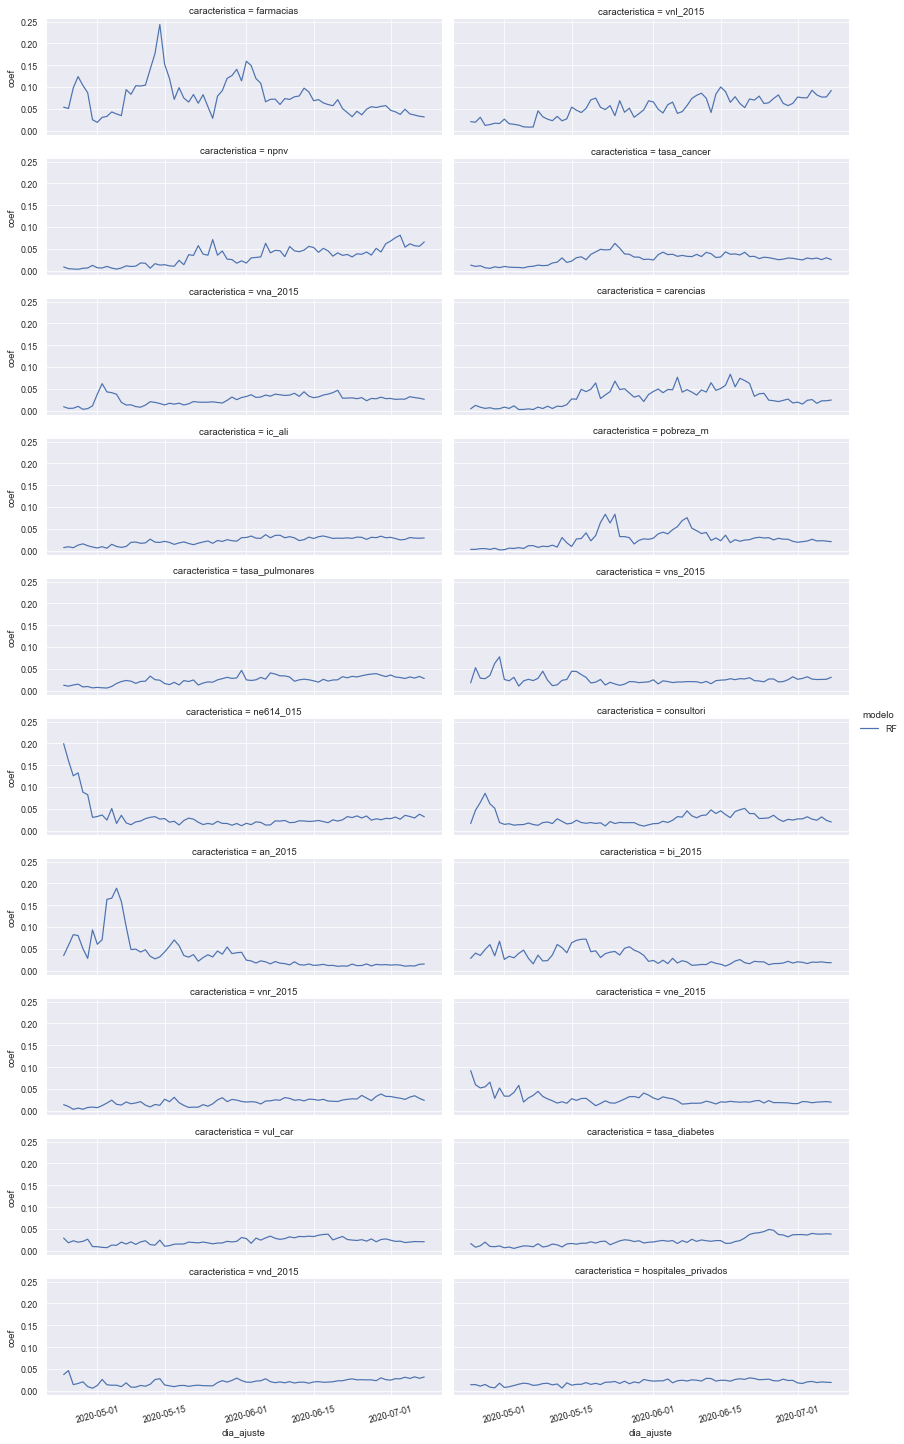

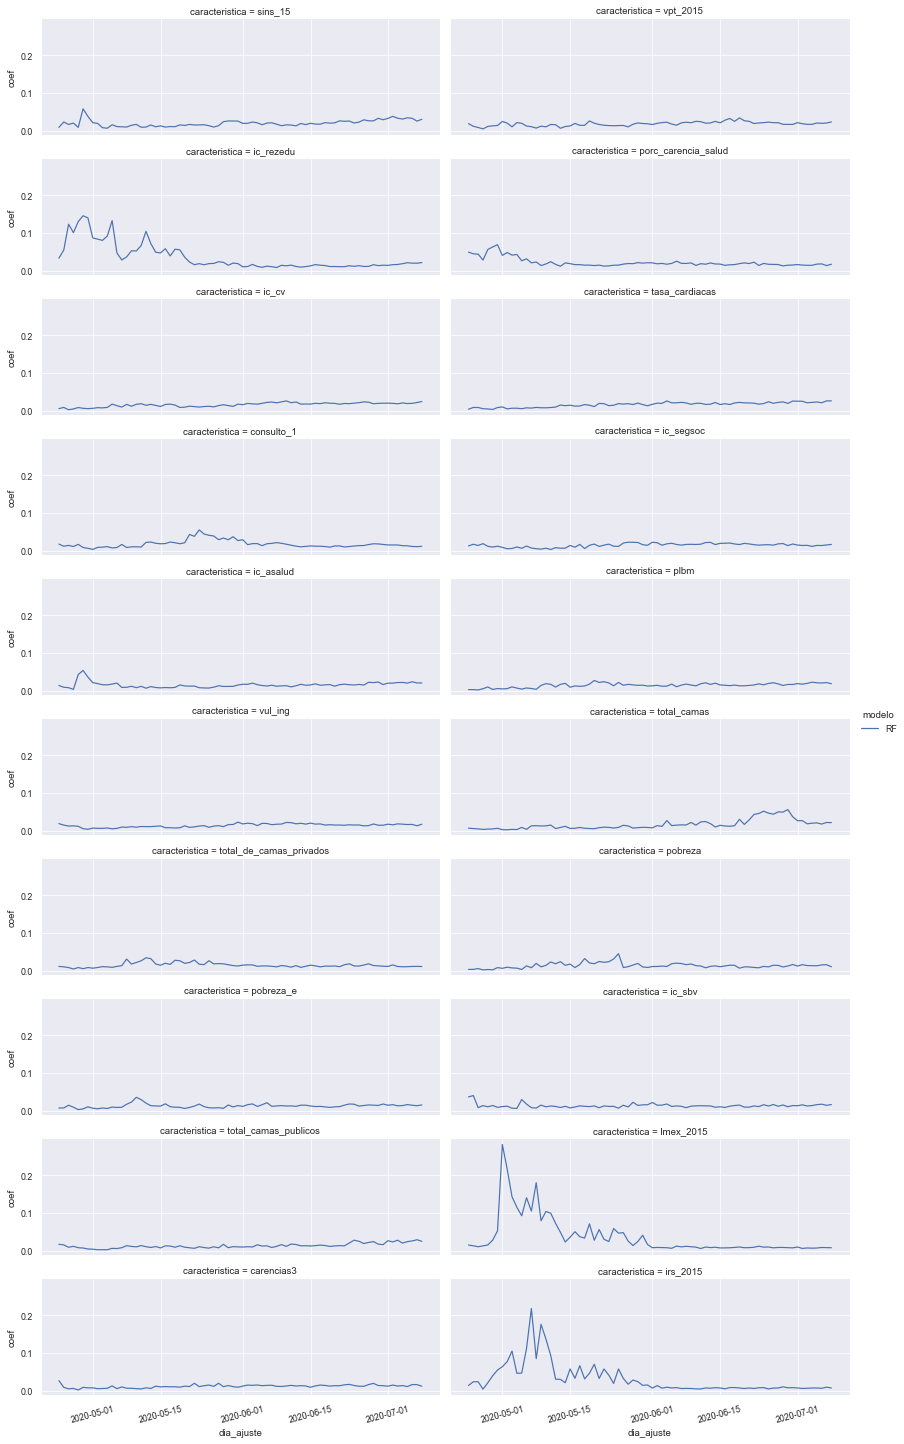

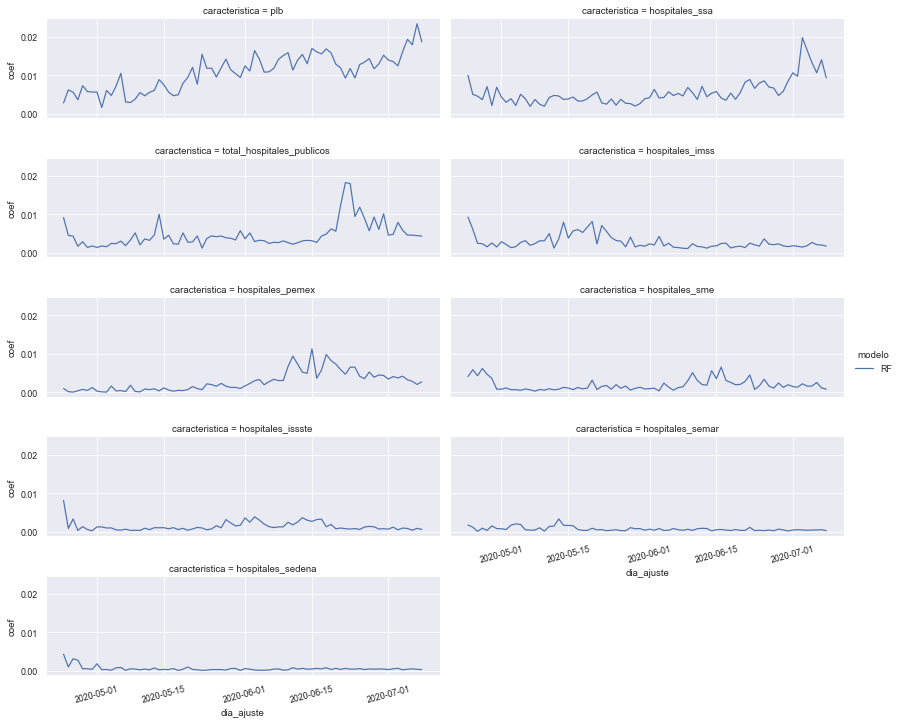

In [ ]:
# ordered_days = tips.day.value_counts().index
modelos_plot = modelos[(modelos.modelo == 'RF')]
orden_plots = modelos_plot.sort_values(by='mediana', ascending=False)['caracteristica'].drop_duplicates()

g = sns.FacetGrid(modelos_plot, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[:20], hue='modelo', legend_out=True)
g = g.map(sns.lineplot, 'dia_ajuste', "coef").add_legend()
g.set_xticklabels(rotation=15)
plt.show()


g = sns.FacetGrid(modelos_plot, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[20:40], hue='modelo')
g = g.map(sns.lineplot, 'dia_ajuste', "coef").add_legend()
g.set_xticklabels(rotation=15)
plt.show()

g = sns.FacetGrid(modelos_plot, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[40:], hue='modelo')
g = g.map(sns.lineplot, 'dia_ajuste', "coef").add_legend()
g.set_xticklabels(rotation=15)
plt.show()


### Distribución de vulnerabilidad según Random Forest

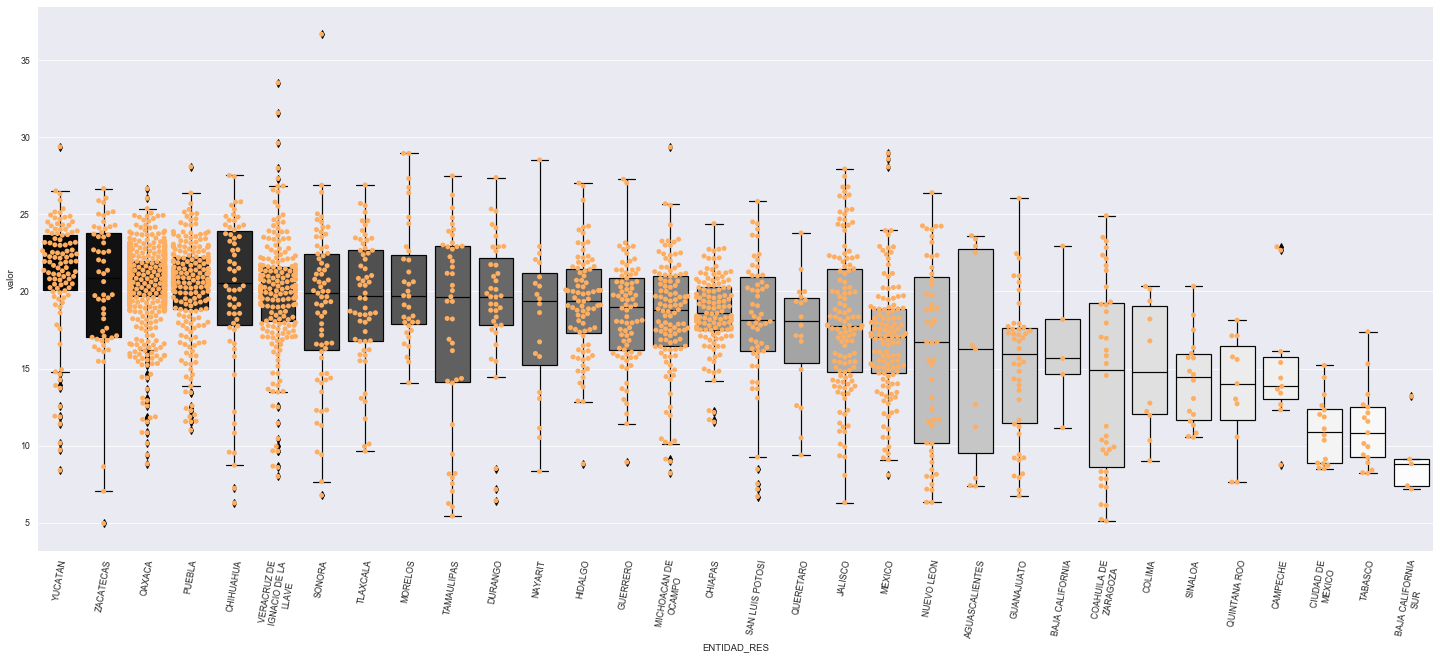

In [ ]:
f, ax = plt.subplots(figsize=(25, 10))
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 7, 1)) &
                          (serie_vulnerabilidad.modelo == 'RF')].copy()
df['mean_val'] = df.groupby('ENTIDAD_RES')['valor'].transform('median')
sns.boxplot(data=df.sort_values(by='mean_val', ascending=False), y='valor', x='ENTIDAD_RES', palette='Greys_r')
sns.swarmplot(data=df.sort_values(by='mean_val', ascending=False), y='valor', x='ENTIDAD_RES', color='#fdae61')
plt.xticks(rotation=80)
sns.despine(trim=True, left=True)

### Correlación entre letalidad y vulnerabilidad RF

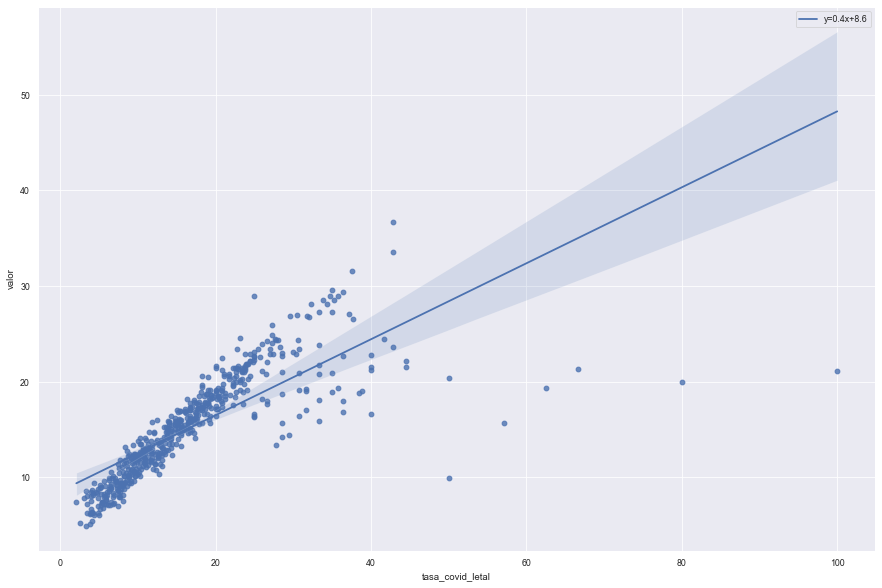

In [ ]:
reg_df = df[(df.defunciones > 3)]
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [ ]:
reg_df = df[(df.defunciones > 3) & df.valor.notna()]
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)
print('Correlación de Spearman: %.3f' % corr)

Correlación de Spearman: 0.941


In [ ]:
tabla = modelos[(modelos.modelo == 'RF') & 
        (modelos.dia_ajuste == datetime.datetime(2020, 7, 1))].sort_values(by='coef',
                                                                            ascending=False).reset_index(drop=True)
display(Markdown(tabla.to_markdown()))

|    | caracteristica            |        coef | dia_ajuste          | modelo   |     mediana |
|---:|:--------------------------|------------:|:--------------------|:---------|------------:|
|  0 | vnl_2015                  | 0.0769857   | 2020-07-01 00:00:00 | RF       | 0.0537434   |
|  1 | npnv                      | 0.0678018   | 2020-07-01 00:00:00 | RF       | 0.0350477   |
|  2 | farmacias                 | 0.046738    | 2020-07-01 00:00:00 | RF       | 0.0711123   |
|  3 | tasa_diabetes             | 0.0369008   | 2020-07-01 00:00:00 | RF       | 0.0210622   |
|  4 | tasa_pulmonares           | 0.0358593   | 2020-07-01 00:00:00 | RF       | 0.024797    |
|  5 | sins_15                   | 0.0326104   | 2020-07-01 00:00:00 | RF       | 0.0191517   |
|  6 | vnr_2015                  | 0.0324976   | 2020-07-01 00:00:00 | RF       | 0.0221137   |
|  7 | ic_ali                    | 0.0306358   | 2020-07-01 00:00:00 | RF       | 0.0251929   |
|  8 | vna_2015                  | 0.0280016   | 2020-07-01 00:00:00 | RF       | 0.0275097   |
|  9 | ne614_015                 | 0.0275513   | 2020-07-01 00:00:00 | RF       | 0.0237626   |
| 10 | consultori                | 0.0269771   | 2020-07-01 00:00:00 | RF       | 0.0237511   |
| 11 | total_camas_publicos      | 0.0263197   | 2020-07-01 00:00:00 | RF       | 0.0121182   |
| 12 | tasa_cancer               | 0.0263036   | 2020-07-01 00:00:00 | RF       | 0.0291333   |
| 13 | total_camas               | 0.0262691   | 2020-07-01 00:00:00 | RF       | 0.0125348   |
| 14 | vns_2015                  | 0.0262101   | 2020-07-01 00:00:00 | RF       | 0.0237942   |
| 15 | tasa_cardiacas            | 0.0250933   | 2020-07-01 00:00:00 | RF       | 0.0171664   |
| 16 | vnd_2015                  | 0.0242523   | 2020-07-01 00:00:00 | RF       | 0.0199611   |
| 17 | vul_car                   | 0.0241519   | 2020-07-01 00:00:00 | RF       | 0.0214613   |
| 18 | vpt_2015                  | 0.0211005   | 2020-07-01 00:00:00 | RF       | 0.0188518   |
| 19 | bi_2015                   | 0.0202741   | 2020-07-01 00:00:00 | RF       | 0.0233237   |
| 20 | ic_cv                     | 0.0199379   | 2020-07-01 00:00:00 | RF       | 0.0172629   |
| 21 | ic_asalud                 | 0.0199114   | 2020-07-01 00:00:00 | RF       | 0.0145589   |
| 22 | carencias                 | 0.0195548   | 2020-07-01 00:00:00 | RF       | 0.0273853   |
| 23 | pobreza_m                 | 0.0192206   | 2020-07-01 00:00:00 | RF       | 0.0249689   |
| 24 | plbm                      | 0.0186866   | 2020-07-01 00:00:00 | RF       | 0.014543    |
| 25 | hospitales_privados       | 0.0179235   | 2020-07-01 00:00:00 | RF       | 0.0195269   |
| 26 | vul_ing                   | 0.0171623   | 2020-07-01 00:00:00 | RF       | 0.0142465   |
| 27 | vne_2015                  | 0.0162565   | 2020-07-01 00:00:00 | RF       | 0.0217543   |
| 28 | porc_carencia_salud       | 0.0161233   | 2020-07-01 00:00:00 | RF       | 0.0180799   |
| 29 | consulto_1                | 0.0151425   | 2020-07-01 00:00:00 | RF       | 0.0150154   |
| 30 | ic_segsoc                 | 0.0147488   | 2020-07-01 00:00:00 | RF       | 0.0146696   |
| 31 | pobreza_e                 | 0.014266    | 2020-07-01 00:00:00 | RF       | 0.0123229   |
| 32 | ic_rezedu                 | 0.0140493   | 2020-07-01 00:00:00 | RF       | 0.018595    |
| 33 | plb                       | 0.0139094   | 2020-07-01 00:00:00 | RF       | 0.0115229   |
| 34 | ic_sbv                    | 0.0129278   | 2020-07-01 00:00:00 | RF       | 0.0122901   |
| 35 | an_2015                   | 0.0127607   | 2020-07-01 00:00:00 | RF       | 0.0233834   |
| 36 | pobreza                   | 0.0121178   | 2020-07-01 00:00:00 | RF       | 0.012326    |
| 37 | carencias3                | 0.0117176   | 2020-07-01 00:00:00 | RF       | 0.0117826   |
| 38 | total_de_camas_privados   | 0.0111087   | 2020-07-01 00:00:00 | RF       | 0.0124936   |
| 39 | hospitales_ssa            | 0.0106138   | 2020-07-01 00:00:00 | RF       | 0.00459464  |
| 40 | lmex_2015                 | 0.00948217  | 2020-07-01 00:00:00 | RF       | 0.0118452   |
| 41 | irs_2015                  | 0.00696939  | 2020-07-01 00:00:00 | RF       | 0.0116715   |
| 42 | total_hospitales_publicos | 0.00462954  | 2020-07-01 00:00:00 | RF       | 0.00379636  |
| 43 | hospitales_pemex          | 0.00343242  | 2020-07-01 00:00:00 | RF       | 0.00201185  |
| 44 | hospitales_imss           | 0.00189082  | 2020-07-01 00:00:00 | RF       | 0.00225627  |
| 45 | hospitales_sme            | 0.00148494  | 2020-07-01 00:00:00 | RF       | 0.00134506  |
| 46 | hospitales_issste         | 0.000647166 | 2020-07-01 00:00:00 | RF       | 0.00099812  |
| 47 | hospitales_semar          | 0.000435049 | 2020-07-01 00:00:00 | RF       | 0.000502896 |
| 48 | hospitales_sedena         | 0.000355317 | 2020-07-01 00:00:00 | RF       | 0.000478448 |

### Correlación entre vulnerabilidad RF y letalidad en el futuro

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 7, 1)) &
                          (serie_vulnerabilidad.modelo == 'RF')]
X_df = df
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 7, 8)) &
                          (serie_vulnerabilidad.modelo == 'RF')]
Y_df = df[df.defunciones > 5]
datos_prueba = Y_df[['CLAVE_MUNICIPIO_RES',
                     'tasa_covid_letal']].merge(X_df[['CLAVE_MUNICIPIO_RES',
                                                      'valor']],
                                                on='CLAVE_MUNICIPIO_RES')

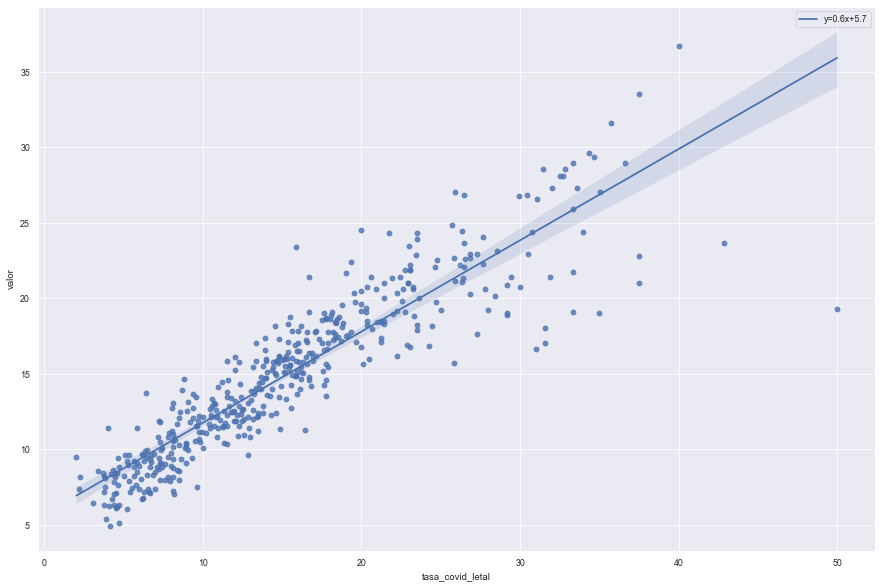

In [ ]:
reg_df = datos_prueba
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [ ]:
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)
print('Correlación de Spearman: %.3f' % corr)

Correlación de Spearman: 0.943


¿Qué tan bien califica los municipios que no estuvieron en el ajuste del RF comparando con el futuro? Es decir los que no tenían más de 20 casos en el ajuste.

### Evaluación con municipios fuera del ajuste en el futuro

En esta evaluación eliminiamos del conjunto de prueba (datos del 08/07/20) todos los municipios que se usaron para el ajuste del 15/06/20

#### PLS
Correlación entre el modelo de vulnerabilidad ajustado el 15/06/2020 y la letalidad del 08/07/20

In [ ]:
ajuste_df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 6, 15))
                          & (serie_vulnerabilidad.conteo > 20)]
ajuste_df = ajuste_df[['CLAVE_MUNICIPIO_RES', 'MUNICIPIO_RES', 'modelo', 'valor']]
prueba_df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 7, 8))
                    & (serie_vulnerabilidad.defunciones > 5)]
prueba_df = prueba_df[~prueba_df.CLAVE_MUNICIPIO_RES.isin(ajuste_df.CLAVE_MUNICIPIO_RES.drop_duplicates())]

X_df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 6, 15))]
Y_df = prueba_df
datos_prueba = Y_df[['CLAVE_MUNICIPIO_RES',
                     'defunciones', 'conteo', 'tasa_covid_letal']].merge(X_df[['CLAVE_MUNICIPIO_RES',
                                                      'valor', 'modelo']],
                                                on='CLAVE_MUNICIPIO_RES', how='left')

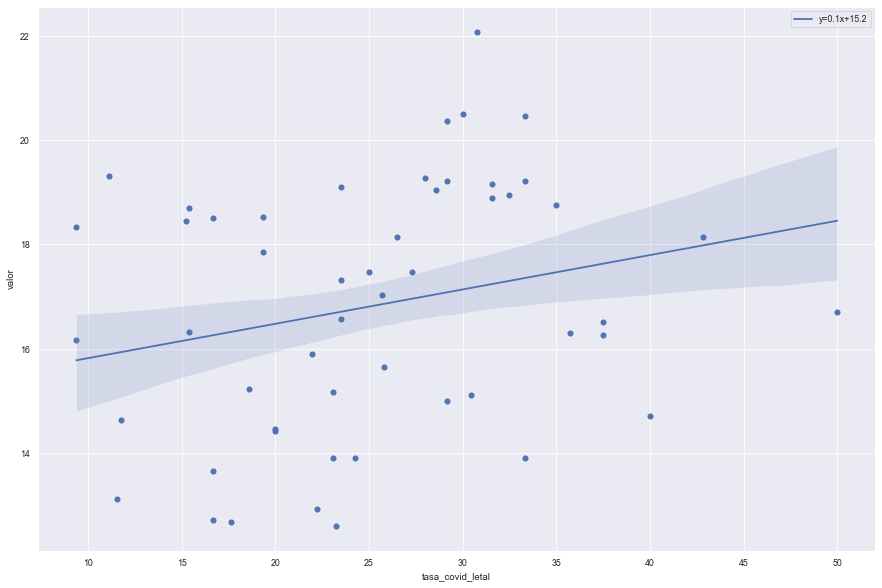

In [ ]:
reg_df = datos_prueba[datos_prueba.modelo == 'PLS']
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [ ]:
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)
print('Correlación de Spearman: %.3f' % corr)

Correlación de Spearman: 0.289


#### Random Forest

Correlación entre el modelo de vulnerabilidad ajustado el 01/06/2020 y la letalidad del 01/07/20

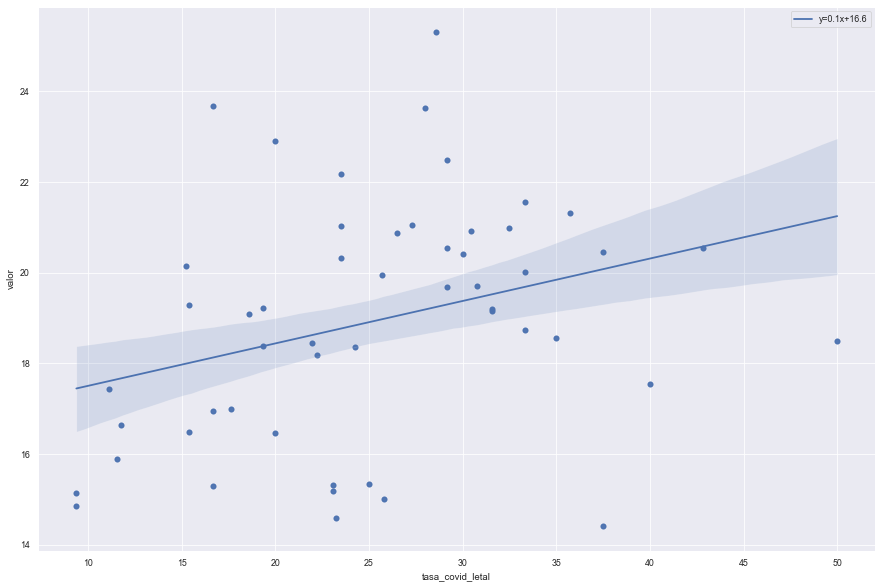

In [ ]:
reg_df = datos_prueba[datos_prueba.modelo == 'RF']
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [ ]:
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)
print('Correlación de Spearman: %.3f' % corr)

Correlación de Spearman: 0.372


In [ ]:
# hide

from nbdev.export import notebook2script
notebook2script()